# Probe: Relationship between purchases and personal attributes

Use with data limited to 2022-10 because data collection began 2022-11

Inferring demographics
- Start with binary Classification (e.g. race=black; etc)
- Preliminary analysis: 
    - Look at differences in top categories and items
- Create feature vectors for each respondent:
    - Feature per item (product code or title)
    - Include items from top products for each category
    - Use item purchase quantity / all purchase quantity 
    - Proprocess and scale feature vectors
        - E.g. https://scikit-learn.org/stable/modules/preprocessing.html
- Initial modeling with:
    - Logistic regression to be interpretable
    - Multilayer perceptron
    - SVM or Simple multilayer perceptron models
    - SVD as part of a pipeline before logistic regression or SVM model


In [1]:
import datetime

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

TOTAL_SPEND = 'spend' # unit price x quantity

YYYY_MM = 'yyyy-mm'
YEAR = 'year'

# Data collection began 2022-11
MAX_YYYY_MM = '2022-10'


## Amazon data

Read in Amazon data.

In [2]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# add date columns for analysis convenience
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
amzn_data[YYYY_MM] = amzn_data[DATE].apply(lambda d: datetime.date.strftime(d, '%Y-%m'))
# add total spend
amzn_data[TOTAL_SPEND] = amzn_data.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
amzn_data.head(3)

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,yyyy-mm,spend
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,2018-12,7.98
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,2018-12,13.99
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF,2018,2018-12,8.99


In [3]:
def print_data_metrics(amazon_data_df):
    print('%s purchases' % len(amazon_data_df))
    print('%s response Ids' % amazon_data_df[RESPONSE_ID].nunique())
    
print_data_metrics(amzn_data)

1850717 purchases
5027 response Ids


Limit data to 2022-10

In [4]:
print('limiting data to up to 2022-10')
amzn_data = amzn_data[amzn_data[YYYY_MM] <= MAX_YYYY_MM]
print_data_metrics(amzn_data)

limiting data to up to 2022-10
1737058 purchases
5015 response Ids


# Survey data setup

Load survey data and connect with purchases.


In [5]:
# only inspect the fields related to demographics of interest for this notebook
demo_fields = [
    'Survey ResponseID', 
    'Q-demos-gender',
    'Q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
    'Q-demos-education', 'Q-demos-income', 
    'Q-sexual-orientation', 
    'Q-demos-state', 
    'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 
    'Q-amazon-use-how-oft',
    'Q-substance-use-cigarettes', 'Q-substance-use-marijuana', 'Q-substance-use-alcohol', 
    'Q-personal-diabetes', 'Q-personal-wheelchair', 
    'Q-life-changes'
]
# Here are the fields
fields_df = pd.read_csv('../data/survey-data/fields.pub.csv', index_col=0).loc[demo_fields]
fields_df

,fields
Survey ResponseID,Response ID
Q-demos-gender,How do you describe yourself?
Q-demos-age,What is your age group?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-education,What is the highest level of education you hav...
Q-demos-income,What was your total household income before ta...
Q-sexual-orientation,Which best describes your sexual orientation?
Q-demos-state,"50 States, D.C. and Puerto Rico"
Q-amazon-use-howmany,How many people do you share your Amazon accou...


In [6]:
# Read in survey data and keep only the columns to be used below
# Want ResponseId, state, and demographic data used to compare purchase behaviors and stratify
survey_data_fpath = '../data/survey-data/survey.pub.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=demo_fields).rename(
        columns={RESPONSE_ID: RESPONSE_ID}
).set_index(RESPONSE_ID)
#Drop rows without Amazon data
response_ids = amzn_data[RESPONSE_ID].unique()
print('%s/%s of survey participants with Amazon data. Restricting survey data to participants with Amazon data.' % (
    len(response_ids), len(survey_df)))
survey_df = survey_df.loc[response_ids].reset_index()
display(survey_df.head(3))

5015/5027 of survey participants with Amazon data. Restricting survey data to participants with Amazon data.


,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use-cigarettes,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes
0,R_01vNIayewjIIKMF,35 - 44 years,Yes,Black or African American,Bachelor's degree,"$25,000 - $49,999",Male,heterosexual (straight),New Jersey,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN
1,R_037XK72IZBJyF69,55 - 64 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Female,heterosexual (straight),Pennsylvania,1 (just me!),2,Less than 5 times per month,No,No,Yes,No,No,NaN
2,R_038ZU6kfQ5f89fH,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),California,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,Lost a job


Set up use of collapsed income and age groups defined as below.

In [7]:
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}
collapse_income_map = {
    'Less than $25,000': 'Less than $50,000', 
    '$25,000 - $49,999': 'Less than $50,000', 
    '$50,000 - $74,999': '\$50,000 - \$99,999',
    '$75,000 - $99,999': '\$50,000 - \$99,999',
    '$100,000 - $149,999': '$100,000 or more',
    '$150,000 or more': '$100,000 or more',
}
survey_df['age-collapsed'] = survey_df['Q-demos-age'].map(collapse_age_map)
survey_df['income-collapsed'] = survey_df['Q-demos-income'].map(collapse_income_map)
survey_df.head(3)

,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use-cigarettes,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,age-collapsed,income-collapsed
0,R_01vNIayewjIIKMF,35 - 44 years,Yes,Black or African American,Bachelor's degree,"$25,000 - $49,999",Male,heterosexual (straight),New Jersey,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN,35 - 54 years,"Less than $50,000"
1,R_037XK72IZBJyF69,55 - 64 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Female,heterosexual (straight),Pennsylvania,1 (just me!),2,Less than 5 times per month,No,No,Yes,No,No,NaN,55 and older,"Less than $50,000"
2,R_038ZU6kfQ5f89fH,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),California,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,Lost a job,18 - 34 years,"Less than $50,000"


## Joined data

Join the Amazon adata and survey data

In [8]:
amzn_data = amzn_data.merge(survey_df, left_on=RESPONSE_ID, right_on=RESPONSE_ID, how='left')
print_data_metrics(amzn_data)
amzn_data.head(3)

1737058 purchases
5015 response Ids


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,yyyy-mm,...,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use-cigarettes,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,age-collapsed,income-collapsed
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,2018-12,...,1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN,35 - 54 years,"Less than $50,000"
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,2018-12,...,1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN,35 - 54 years,"Less than $50,000"
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF,2018,2018-12,...,1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN,35 - 54 years,"Less than $50,000"


In [9]:
data_df = amzn_data

# Exploratory analysis

## Race and ethnicity set up: Booleans

Add booleans indicating whether someone is Hispanic or a certain race.

Boolean added if they answered with the race at all -- not only.
i.e. someone is marked as "Black" even when they checked off "Black" and "Asian" and ...
There is no extra consideration of mixed race.

### Hispanic

In [10]:
# add boolean to make this data easier to work with
data_df['Hispanic'] = data_df['Q-demos-hispanic'].apply(lambda h: h=='Yes')
print('%0.3f = %s/%s respondents reported as Hispanic' % (
    data_df.drop_duplicates(RESPONSE_ID)['Hispanic'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)),
    data_df.drop_duplicates(RESPONSE_ID)['Hispanic'].sum(), 
    len(data_df.drop_duplicates(RESPONSE_ID))))

0.109 = 548/5015 respondents reported as Hispanic


### Race

In [11]:
# Add boolean indicating whether white is included in race answer
data_df['White'] = data_df['Q-demos-race'].apply(lambda race: 'White' in str(race))
# What fraction of the respondents are black?
print('%s White ResponseIds (dropped duplicates)' % data_df.drop_duplicates(RESPONSE_ID)['White'].sum())
print('%s = portion of White ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['White'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))

# Add boolean indicating whether black is included in race answer
data_df['Black'] = data_df['Q-demos-race'].apply(lambda race: 'Black' in str(race))
# What fraction of the respondents are black?
print('%s Black ResponseIds (dropped duplicates)' % data_df.drop_duplicates(RESPONSE_ID)['Black'].sum())
print('%s = portion of Black ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['Black'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))

# Add boolean indicating whether black is included in race answer
data_df['Asian'] = data_df['Q-demos-race'].apply(lambda race: 'Asian' in str(race))
# What fraction of the respondents are black?
print('%s Asian ResponseIds (dropped duplicates)' % data_df.drop_duplicates(RESPONSE_ID)['Asian'].sum())
print('%s = portion of Asian ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['Asian'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))
data_df[list(data_df.columns[:6])+['Q-demos-race', 'Asian', 'Black', 'White', 'Hispanic']].head(3)

4126 White ResponseIds (dropped duplicates)
0.8227 = portion of White ResponseIds (dropped duplicates)
446 Black ResponseIds (dropped duplicates)
0.0889 = portion of Black ResponseIds (dropped duplicates)
482 Asian ResponseIds (dropped duplicates)
0.0961 = portion of Asian ResponseIds (dropped duplicates)


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Q-demos-race,Asian,Black,White,Hispanic
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,Black or African American,False,True,False,True
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,Black or African American,False,True,False,True
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,Black or African American,False,True,False,True


### Sexuality

In [12]:
Q = 'Q-sexual-orientation'
display(data_df.drop_duplicates(RESPONSE_ID)[Q].value_counts())
# Add boolean indicating whether LGBTQ+
data_df['LGBTQ+'] = data_df[Q].apply(lambda resp: 'LGBTQ+' in str(resp))
print('%s LGBTQ+ ResponseIds (dropped duplicates)' % data_df.drop_duplicates(RESPONSE_ID)['LGBTQ+'].sum())
print('%s = portion of LGBTQ+ ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['LGBTQ+'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))

Q-sexual-orientation
heterosexual (straight)    3847
LGBTQ+                     1110
prefer not to say            58
Name: count, dtype: int64

1110 LGBTQ+ ResponseIds (dropped duplicates)
0.2213 = portion of LGBTQ+ ResponseIds (dropped duplicates)


### Personal 
- Q-personal_1: Have diabetes? 
- Q-personal_2: Use a wheelchair? 
- Answers can be: Y / N / Prefer not to say

In [13]:
Q = 'Q-personal-diabetes'
display(data_df.drop_duplicates(RESPONSE_ID)[Q].value_counts())
# Add boolean indicating whether LGBTQ+
data_df['Diabetes'] = data_df[Q].apply(lambda resp: resp=='Yes')
print('%s diabetes ResponseIds' % data_df.drop_duplicates(RESPONSE_ID)['Diabetes'].sum())
print('%s = portion of Diabetes ResponseIds'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['Diabetes'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))

Q = 'Q-personal-wheelchair'
print('\n\nUse a wheelchair?')
display(data_df.drop_duplicates(RESPONSE_ID)[Q].value_counts())
# Add boolean indicating whether LGBTQ+
data_df['Wheelchair'] = data_df[Q].apply(lambda resp: resp=='Yes')
print('%s ResponseIds' % data_df.drop_duplicates(RESPONSE_ID)['Wheelchair'].sum())
print('%s = portion of ResponseIds'% (
    round(data_df.drop_duplicates(RESPONSE_ID)['Wheelchair'].sum()/len(data_df.drop_duplicates(RESPONSE_ID)), 4)))

Q-personal-diabetes
No                   4383
Yes                   616
Prefer not to say      16
Name: count, dtype: int64

616 diabetes ResponseIds
0.1228 = portion of Diabetes ResponseIds


Use a wheelchair?


Q-personal-wheelchair
No                   4906
Yes                    98
Prefer not to say      11
Name: count, dtype: int64

98 ResponseIds
0.0195 = portion of ResponseIds


### Understanding the data

- What is the distribution of number of unique orders per person? Does this differ by demographic group?
- Distribution of number of unique categories per person?
- Distribution of number of unique products per person?

In [14]:
def plot_unique_orders_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of order dates')
        _ = ax.set_title('Histogram of number of order dates: %s' % cat) 
    counts = df.groupby(RESPONSE_ID)['Order Date'].nunique() 
    _ = ax.hist(counts, bins=bins, label=cat,density=True)
    if legend:
        ax.legend()

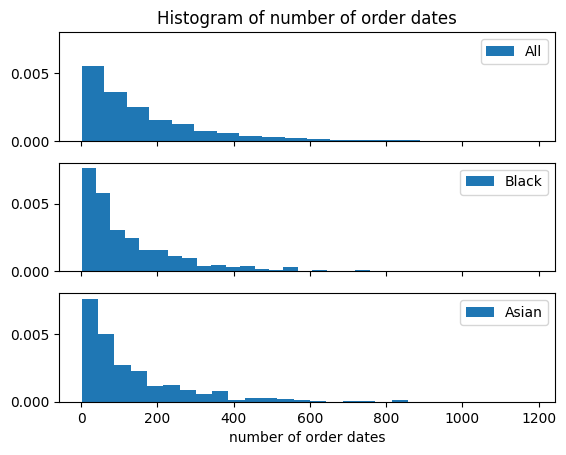

In [15]:
fig, axes = plt.subplots(3,1, sharex=True,sharey=True)
axes[2].set_xlabel('number of order dates')
axes[0].set_title('Histogram of number of order dates')
plot_unique_orders_hist(data_df, ax=axes[0])
plot_unique_orders_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_orders_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

In [16]:
def plot_unique_products_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of unique products')
        _ = ax.set_title('Histogram of number of unique products ordered: %s' % cat)
    counts = df.groupby(RESPONSE_ID)['ASIN/ISBN (Product Code)'].nunique()
    _ = ax.hist(counts, bins=bins, label=cat, density=True)
    if legend:
        ax.legend()

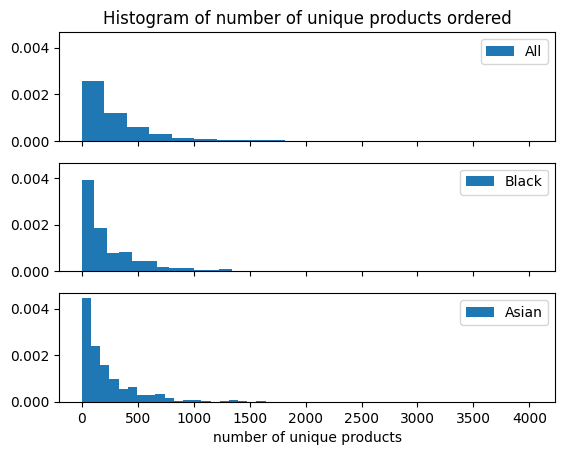

In [17]:
fig, axes = plt.subplots(3,1, sharex=True,sharey=True)
axes[2].set_xlabel('number of unique products')
axes[0].set_title('Histogram of number of unique products ordered')
plot_unique_products_hist(data_df, ax=axes[0])
plot_unique_products_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_products_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

In [18]:
def plot_unique_categories_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of unique categories')
        _ = ax.set_title('Histogram of number of unique categories ordered: %s' % cat)
    counts = df.groupby(RESPONSE_ID)['Category'].nunique()
    _ = ax.hist(counts, bins=bins, label=cat, density=True)
    if legend:
        ax.legend()

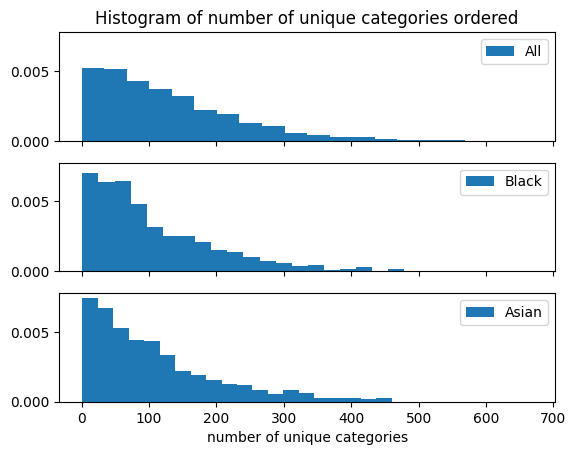

In [19]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True)
axes[2].set_xlabel('number of unique categories')
axes[0].set_title('Histogram of number of unique categories ordered')
plot_unique_categories_hist(data_df, ax=axes[0])
plot_unique_categories_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_categories_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

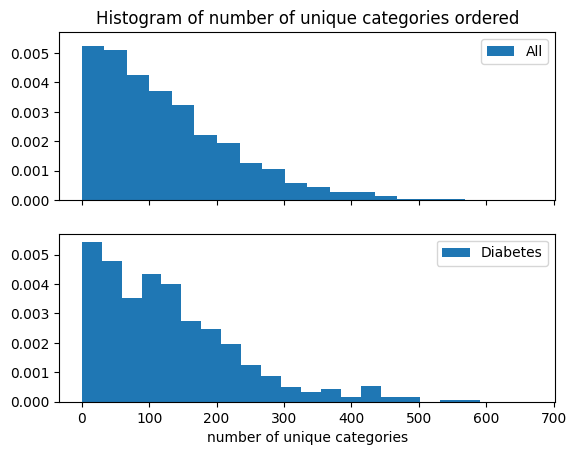

In [20]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
axes[1].set_xlabel('number of unique categories')
axes[0].set_title('Histogram of number of unique categories ordered')
plot_unique_categories_hist(data_df, ax=axes[0])
plot_unique_categories_hist(data_df[data_df['Diabetes']], cat='Diabetes', ax=axes[1])

In general what is the best way to look at the top categories or the top items 
in order to feature engineer?

In [21]:
# how many categories?
categories = data_df['Category'].to_list()
data_df['Category'].nunique()

1870

In [22]:
# top categories
# total top categories in terms of number of purchases
data_df['Category'].value_counts().head(10)

Category
ABIS_BOOK                 83070
PET_FOOD                  35922
GIFT_CARD                 26652
SHIRT                     25711
NUTRITIONAL_SUPPLEMENT    25229
ELECTRONIC_CABLE          17294
HEALTH_PERSONAL_CARE      15826
MEDICATION                14926
PANTS                     14791
CELLULAR_PHONE_CASE       14493
Name: count, dtype: int64

In [23]:
orders_threshold = 100
# restrict to categories with at least threshold number of orders
print('restricting categories to those with %s orders' % orders_threshold)
categories = (data_df['Category'].value_counts() > orders_threshold)
categories = categories[categories].index.to_list()
print('%s filtered categories' % len(categories))
# restrict to categories with at least threshold number of orders from different people
ppl_threshold = 50
cats_ppl = data_df.groupby(['Category'])[RESPONSE_ID].nunique().sort_values(ascending=False)
cats_ppl = cats_ppl[(cats_ppl > ppl_threshold)].index.to_list()
print('%s filtered categories when restricting to categories ordered from %s unique people' % (
len(cats_ppl), ppl_threshold))
# categories under both restrictiosn
categories = list(set(categories).intersection(set(cats_ppl)))
print('%s filtered categories applying both filtering methods' % len(categories))

restricting categories to those with 100 orders
1228 filtered categories
1357 filtered categories when restricting to categories ordered from 50 unique people
1223 filtered categories applying both filtering methods


In [24]:
def get_relative_spend(df, cat):
    """
    Returns relative spend on category as median of ( ($ spend for category / total spend) per person)
    Note: Median is restricted to people who ordered the item at all. Otherwise returns 0s.
    """
    cdf = df[df['Category']==cat]
    cat_spend_by_responseId = cdf.groupby(RESPONSE_ID)[TOTAL_SPEND].sum()
    total_spend_by_responseId = (df[df[RESPONSE_ID].isin(cdf[RESPONSE_ID].unique())]
                                  .groupby(RESPONSE_ID)[TOTAL_SPEND].sum())
    return (cat_spend_by_responseId/total_spend_by_responseId).median()

In [25]:
def get_relative_popularity(df, cat):
    """
    Returns relative popularity of category as median of ( (# orders for category / total orders) per person)
    Note: Median is restricted to people who ordered the item at all. Otherwise returns 0s.
    """
    cdf = df[df['Category']==cat]
    cat_orders_by_responseId = cdf.groupby(RESPONSE_ID)['Order Date'].count()
    total_orders_by_responseId = (df.groupby(RESPONSE_ID)['Order Date'].count())
    return (cat_orders_by_responseId/total_orders_by_responseId).median()

In [26]:
def get_relative_purchasers(df, cat):
    """
    Returns the portion of people who have purchased this item.
    Idea: help us select categories/products to make features vectors with that are not so sparse
    """
    cdf = df[df['Category']==cat]
    return cdf[RESPONSE_ID].nunique()/df[RESPONSE_ID].nunique()

In [27]:
rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_purchasers_list += [get_relative_purchasers(data_df, cat)]

2024-05-02 21:05:54.347042: 0/1223
2024-05-02 21:06:03.396964: 100/1223
2024-05-02 21:06:12.344865: 200/1223
2024-05-02 21:06:21.363454: 300/1223
2024-05-02 21:06:30.452836: 400/1223
2024-05-02 21:06:39.590041: 500/1223
2024-05-02 21:06:48.696844: 600/1223
2024-05-02 21:06:58.002853: 700/1223
2024-05-02 21:07:07.107569: 800/1223
2024-05-02 21:07:16.217436: 900/1223
2024-05-02 21:07:25.325938: 1000/1223
2024-05-02 21:07:34.447749: 1100/1223
2024-05-02 21:07:43.602503: 1200/1223


In [28]:
cat_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
cat_rel_purchasers.head(15)

,Category,relative purchasers
342,ABIS_BOOK,0.835095
871,ELECTRONIC_CABLE,0.689930
761,CELLULAR_PHONE_CASE,0.677966
62,SHIRT,0.654237
569,HEADPHONES,0.641874
274,HEALTH_PERSONAL_CARE,0.624925
706,CHARGING_ADAPTER,0.551944
658,SHOES,0.540578
181,NUTRITIONAL_SUPPLEMENT,0.536590
335,PANTS,0.529412


In [29]:
rel_spend_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_spend_list += [get_relative_spend(data_df, cat)]

2024-05-02 21:07:45.694850: 0/1223
2024-05-02 21:08:02.485219: 100/1223
2024-05-02 21:08:17.710534: 200/1223
2024-05-02 21:08:33.761081: 300/1223
2024-05-02 21:08:49.767118: 400/1223
2024-05-02 21:09:07.044566: 500/1223
2024-05-02 21:09:22.917891: 600/1223
2024-05-02 21:09:38.905471: 700/1223
2024-05-02 21:09:54.241520: 800/1223
2024-05-02 21:10:10.470585: 900/1223
2024-05-02 21:10:26.142646: 1000/1223
2024-05-02 21:10:41.920964: 1100/1223
2024-05-02 21:10:57.282624: 1200/1223


In [30]:
cat_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': rel_spend_list
}).sort_values('relative spend', ascending=False)
cat_rel_spend.head(15)

,Category,relative spend
67,NOTEBOOK_COMPUTER,0.058792
591,CELLULAR_PHONE,0.036712
143,VIDEO_CARD,0.033088
817,TREADMILL,0.032310
457,TELEVISION,0.029666
221,PERSONAL_COMPUTER,0.029234
1114,COMPUTER_PROCESSOR,0.027103
342,ABIS_BOOK,0.025331
408,TABLET_COMPUTER,0.024884
872,MONITOR,0.023837


In [31]:
rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_popularity_list += [get_relative_popularity(data_df, cat)]

2024-05-02 21:11:00.568055: 0/1223
2024-05-02 21:11:11.252584: 100/1223
2024-05-02 21:11:21.681984: 200/1223
2024-05-02 21:11:32.084164: 300/1223
2024-05-02 21:11:42.403005: 400/1223
2024-05-02 21:11:52.520509: 500/1223
2024-05-02 21:12:02.750673: 600/1223
2024-05-02 21:12:12.837824: 700/1223
2024-05-02 21:12:22.979070: 800/1223
2024-05-02 21:12:33.099018: 900/1223
2024-05-02 21:12:43.276373: 1000/1223
2024-05-02 21:12:53.388093: 1100/1223
2024-05-02 21:13:03.585047: 1200/1223


In [32]:
cat_rel_pop = pd.DataFrame({
    'Category': categories,
    'relative orders': rel_popularity_list
}).sort_values('relative orders', ascending=False)
cat_rel_pop.head(15)

,Category,relative orders
342,ABIS_BOOK,0.040962
588,PET_FOOD,0.016152
62,SHIRT,0.014493
835,GIFT_CARD,0.012435
181,NUTRITIONAL_SUPPLEMENT,0.011879
871,ELECTRONIC_CABLE,0.011326
335,PANTS,0.010381
761,CELLULAR_PHONE_CASE,0.010204
508,VEGETABLE,0.009524
274,HEALTH_PERSONAL_CARE,0.009217


In [33]:
# get the same list for people who answered yes to the diabetes Q
diabetes_data_df = data_df[data_df['Diabetes']]

In [34]:
diabetes_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_purchasers_list += [get_relative_purchasers(diabetes_data_df, cat)]
diabetes_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': diabetes_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
diabetes_rel_purchasers.head(15)

2024-05-02 21:13:05.974753: 0/1223
2024-05-02 21:13:07.205506: 100/1223
2024-05-02 21:13:08.424094: 200/1223
2024-05-02 21:13:09.651822: 300/1223
2024-05-02 21:13:10.882203: 400/1223
2024-05-02 21:13:12.104984: 500/1223
2024-05-02 21:13:13.329623: 600/1223
2024-05-02 21:13:14.550048: 700/1223
2024-05-02 21:13:15.768106: 800/1223
2024-05-02 21:13:16.990302: 900/1223
2024-05-02 21:13:18.208146: 1000/1223
2024-05-02 21:13:19.429672: 1100/1223
2024-05-02 21:13:20.644383: 1200/1223


,Category,relative purchasers
342,ABIS_BOOK,0.813312
871,ELECTRONIC_CABLE,0.709416
274,HEALTH_PERSONAL_CARE,0.670455
569,HEADPHONES,0.660714
761,CELLULAR_PHONE_CASE,0.657468
62,SHIRT,0.647727
706,CHARGING_ADAPTER,0.564935
181,NUTRITIONAL_SUPPLEMENT,0.560065
8,BATTERY,0.545455
658,SHOES,0.540584


In [35]:
diabetes_rel_spend_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_spend_list += [get_relative_spend(diabetes_data_df, cat)]

2024-05-02 21:13:20.930446: 0/1223
2024-05-02 21:13:23.195082: 100/1223
2024-05-02 21:13:25.218145: 200/1223
2024-05-02 21:13:27.371879: 300/1223
2024-05-02 21:13:29.566021: 400/1223
2024-05-02 21:13:31.869865: 500/1223
2024-05-02 21:13:34.038005: 600/1223
2024-05-02 21:13:36.238777: 700/1223
2024-05-02 21:13:38.367293: 800/1223
2024-05-02 21:13:40.645265: 900/1223
2024-05-02 21:13:42.826707: 1000/1223
2024-05-02 21:13:44.938796: 1100/1223
2024-05-02 21:13:47.032387: 1200/1223


In [36]:
diabetes_cat_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': diabetes_rel_spend_list
}).sort_values('relative spend', ascending=False)
diabetes_cat_rel_spend.head(15)

,Category,relative spend
67,NOTEBOOK_COMPUTER,0.059367
817,TREADMILL,0.036678
591,CELLULAR_PHONE,0.032699
872,MONITOR,0.029523
143,VIDEO_CARD,0.029374
221,PERSONAL_COMPUTER,0.022719
264,MATTRESS,0.022392
342,ABIS_BOOK,0.021902
408,TABLET_COMPUTER,0.021035
457,TELEVISION,0.020325


In [37]:
diabetes_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_popularity_list += [get_relative_popularity(diabetes_data_df, cat)]

2024-05-02 21:13:47.481267: 0/1223
2024-05-02 21:13:48.890518: 100/1223
2024-05-02 21:13:50.290383: 200/1223
2024-05-02 21:13:51.689311: 300/1223
2024-05-02 21:13:53.141484: 400/1223
2024-05-02 21:13:54.546064: 500/1223
2024-05-02 21:13:55.941090: 600/1223
2024-05-02 21:13:57.391916: 700/1223
2024-05-02 21:13:58.777945: 800/1223
2024-05-02 21:14:00.178217: 900/1223
2024-05-02 21:14:01.573292: 1000/1223
2024-05-02 21:14:02.970519: 1100/1223
2024-05-02 21:14:04.354459: 1200/1223


In [38]:
diabetes_cat_rel_pop = pd.DataFrame({
    'Category': categories[:len(diabetes_rel_popularity_list)],
    'relative orders': diabetes_rel_popularity_list
}).sort_values('relative orders', ascending=False)
diabetes_cat_rel_pop.head(20)

,Category,relative orders
342,ABIS_BOOK,0.035994
62,SHIRT,0.014151
588,PET_FOOD,0.013914
835,GIFT_CARD,0.012987
181,NUTRITIONAL_SUPPLEMENT,0.012770
871,ELECTRONIC_CABLE,0.012647
761,CELLULAR_PHONE_CASE,0.011494
274,HEALTH_PERSONAL_CARE,0.010135
971,MEDICATION,0.008811
569,HEADPHONES,0.008621


In [39]:
# How to select which to use as features?
# a rule of thumb is to use 15x more parameters than events
print('try ~ %s parameters'%20)
top_pop_cats = cat_rel_pop

try ~ 20 parameters


In [40]:
# take the top 20 categories that ppl with diabetes have purchased from
diab_tcats = diabetes_rel_purchasers.head(20)['Category'].to_list()
# and then plot their relative popularity

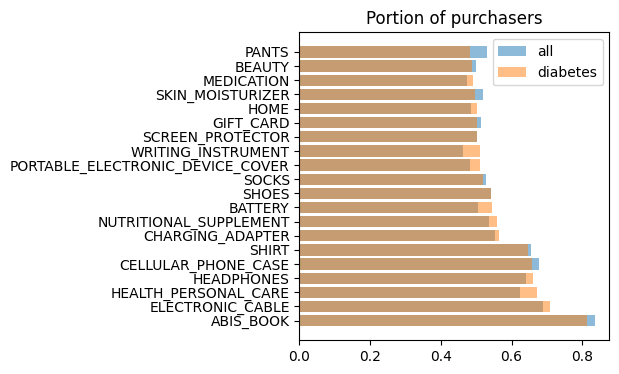

In [41]:
tcats = diab_tcats
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Portion of purchasers')
ax.barh(tcats, cat_rel_purchasers.set_index('Category').loc[tcats]['relative purchasers'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_rel_purchasers.set_index('Category').loc[tcats]['relative purchasers'], alpha=0.5, label='diabetes')
_ = ax.legend()

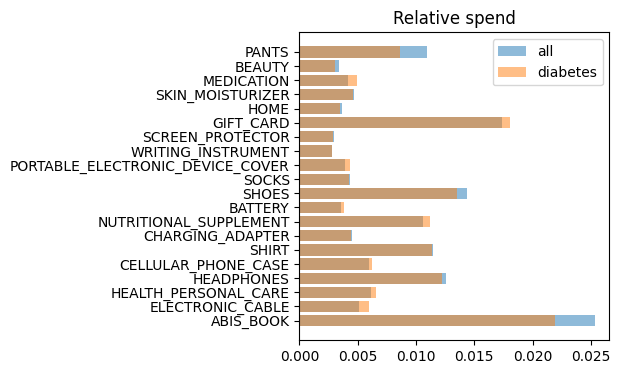

In [42]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative spend')
ax.barh(tcats, cat_rel_spend.set_index('Category').loc[tcats]['relative spend'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_cat_rel_spend.set_index('Category').loc[tcats]['relative spend'], alpha=0.5, label='diabetes')
_ = ax.legend()

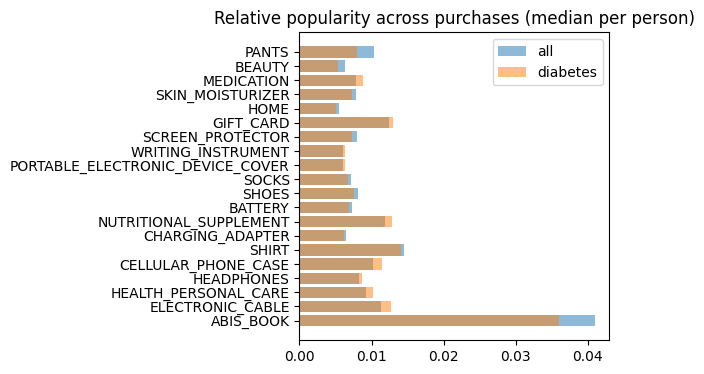

In [43]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='diabetes')
_ = ax.legend()

### Race and ethnicity comparisons

In [44]:
black_data_df = data_df[data_df['Black']]
asian_data_df = data_df[data_df['Asian']]
hisp_data_df = data_df[data_df['Hispanic']]

In [45]:
black_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    black_rel_purchasers_list += [get_relative_purchasers(black_data_df, cat)]
black_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': black_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
black_rel_purchasers.head(15)

2024-05-02 21:14:05.201328: 0/1223
2024-05-02 21:14:05.905643: 100/1223
2024-05-02 21:14:06.606481: 200/1223
2024-05-02 21:14:07.305374: 300/1223
2024-05-02 21:14:08.006605: 400/1223
2024-05-02 21:14:08.714337: 500/1223
2024-05-02 21:14:09.426973: 600/1223
2024-05-02 21:14:10.133327: 700/1223
2024-05-02 21:14:10.832233: 800/1223
2024-05-02 21:14:11.536155: 900/1223
2024-05-02 21:14:12.246538: 1000/1223
2024-05-02 21:14:12.945499: 1100/1223
2024-05-02 21:14:13.644284: 1200/1223


,Category,relative purchasers
342,ABIS_BOOK,0.784753
871,ELECTRONIC_CABLE,0.656951
761,CELLULAR_PHONE_CASE,0.647982
569,HEADPHONES,0.645740
62,SHIRT,0.585202
274,HEALTH_PERSONAL_CARE,0.556054
403,SKIN_MOISTURIZER,0.542601
658,SHOES,0.511211
706,CHARGING_ADAPTER,0.502242
181,NUTRITIONAL_SUPPLEMENT,0.497758


In [46]:
asian_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    asian_rel_purchasers_list += [get_relative_purchasers(asian_data_df, cat)]
asian_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': asian_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
asian_rel_purchasers.head(15)

2024-05-02 21:14:13.810655: 0/1223
2024-05-02 21:14:14.517595: 100/1223
2024-05-02 21:14:15.208552: 200/1223
2024-05-02 21:14:15.902587: 300/1223
2024-05-02 21:14:16.598878: 400/1223
2024-05-02 21:14:17.299912: 500/1223
2024-05-02 21:14:17.992793: 600/1223
2024-05-02 21:14:18.691411: 700/1223
2024-05-02 21:14:19.382360: 800/1223
2024-05-02 21:14:20.078567: 900/1223
2024-05-02 21:14:20.777484: 1000/1223
2024-05-02 21:14:21.468855: 1100/1223
2024-05-02 21:14:22.165286: 1200/1223


,Category,relative purchasers
342,ABIS_BOOK,0.755187
761,CELLULAR_PHONE_CASE,0.663900
871,ELECTRONIC_CABLE,0.651452
569,HEADPHONES,0.628631
274,HEALTH_PERSONAL_CARE,0.553942
403,SKIN_MOISTURIZER,0.545643
835,GIFT_CARD,0.539419
62,SHIRT,0.537344
941,SCREEN_PROTECTOR,0.533195
706,CHARGING_ADAPTER,0.497925


In [47]:
black_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    black_rel_popularity_list += [get_relative_popularity(black_data_df, cat)]
black_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': black_rel_popularity_list
}).sort_values('relative orders', ascending=False)
black_rel_popularity.head(15)

2024-05-02 21:14:22.329178: 0/1223
2024-05-02 21:14:23.132100: 100/1223
2024-05-02 21:14:23.938259: 200/1223
2024-05-02 21:14:24.742344: 300/1223
2024-05-02 21:14:25.543856: 400/1223
2024-05-02 21:14:26.329731: 500/1223
2024-05-02 21:14:27.114885: 600/1223


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2024-05-02 21:14:27.918441: 700/1223
2024-05-02 21:14:28.713768: 800/1223
2024-05-02 21:14:29.512255: 900/1223
2024-05-02 21:14:30.308810: 1000/1223
2024-05-02 21:14:31.111811: 1100/1223


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2024-05-02 21:14:31.897173: 1200/1223


,Category,relative orders
342,ABIS_BOOK,0.032893
1146,CYCLING_TIRE_TUBE,0.032258
1205,TELESCOPE,0.026700
527,WHEEL,0.020422
227,WEIGHT_PLATE,0.019772
508,VEGETABLE,0.016393
835,GIFT_CARD,0.015873
62,SHIRT,0.015038
181,NUTRITIONAL_SUPPLEMENT,0.014011
761,CELLULAR_PHONE_CASE,0.013575


In [48]:
asian_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    asian_rel_popularity_list += [get_relative_popularity(asian_data_df, cat)]
asian_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': asian_rel_popularity_list
}).sort_values('relative orders', ascending=False)
asian_rel_popularity.head(15)

2024-05-02 21:14:32.086490: 0/1223
2024-05-02 21:14:32.892435: 100/1223
2024-05-02 21:14:33.685929: 200/1223
2024-05-02 21:14:34.464327: 300/1223
2024-05-02 21:14:35.271990: 400/1223
2024-05-02 21:14:36.069595: 500/1223
2024-05-02 21:14:36.861501: 600/1223
2024-05-02 21:14:37.653931: 700/1223
2024-05-02 21:14:38.449429: 800/1223
2024-05-02 21:14:39.231458: 900/1223


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2024-05-02 21:14:40.024632: 1000/1223
2024-05-02 21:14:40.818280: 1100/1223
2024-05-02 21:14:41.595437: 1200/1223


,Category,relative orders
342,ABIS_BOOK,0.037665
936,AIR_GUN,0.016667
835,GIFT_CARD,0.016195
181,NUTRITIONAL_SUPPLEMENT,0.014508
705,BRA_UNDERWEAR_SET,0.014309
871,ELECTRONIC_CABLE,0.014236
1181,ANIMAL_MEDICATION,0.013920
588,PET_FOOD,0.013587
941,SCREEN_PROTECTOR,0.011905
62,SHIRT,0.011905


In [49]:
# Hispanic
hisp_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    hisp_rel_popularity_list += [get_relative_popularity(hisp_data_df, cat)]
hisp_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': hisp_rel_popularity_list
}).sort_values('relative orders', ascending=False)
hisp_rel_popularity.head(15)

2024-05-02 21:14:41.782619: 0/1223
2024-05-02 21:14:42.765282: 100/1223
2024-05-02 21:14:43.732849: 200/1223
2024-05-02 21:14:44.689280: 300/1223
2024-05-02 21:14:45.666079: 400/1223
2024-05-02 21:14:46.638749: 500/1223
2024-05-02 21:14:47.596154: 600/1223
2024-05-02 21:14:48.555616: 700/1223
2024-05-02 21:14:49.530850: 800/1223
2024-05-02 21:14:50.512911: 900/1223
2024-05-02 21:14:51.472599: 1000/1223
2024-05-02 21:14:52.447683: 1100/1223
2024-05-02 21:14:53.400085: 1200/1223


,Category,relative orders
342,ABIS_BOOK,0.034483
62,SHIRT,0.014925
871,ELECTRONIC_CABLE,0.014311
835,GIFT_CARD,0.013356
508,VEGETABLE,0.012739
588,PET_FOOD,0.012626
761,CELLULAR_PHONE_CASE,0.012423
181,NUTRITIONAL_SUPPLEMENT,0.012346
335,PANTS,0.011585
569,HEADPHONES,0.010204


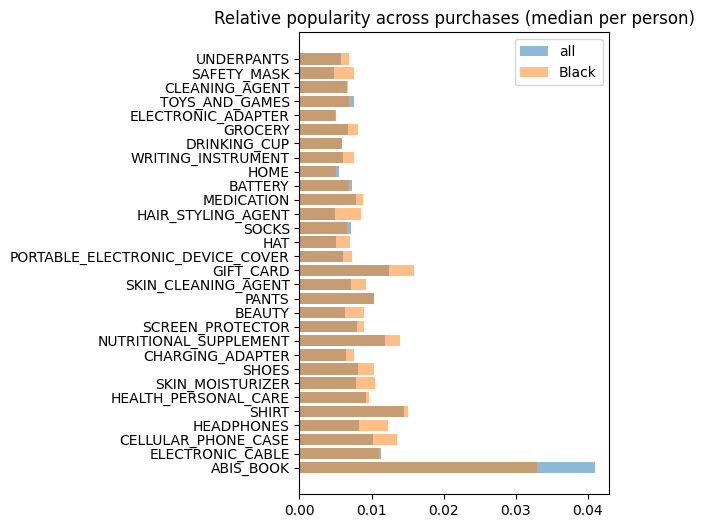

In [50]:
# take the top X categories that ppl in category have purchased from
tcats = black_rel_purchasers.head(30)['Category'].to_list()
# and then plot their relative popularity
# tcats
# see HAIR_STYLING_AGENT
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, black_rel_popularity.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='Black')
_ = ax.legend()

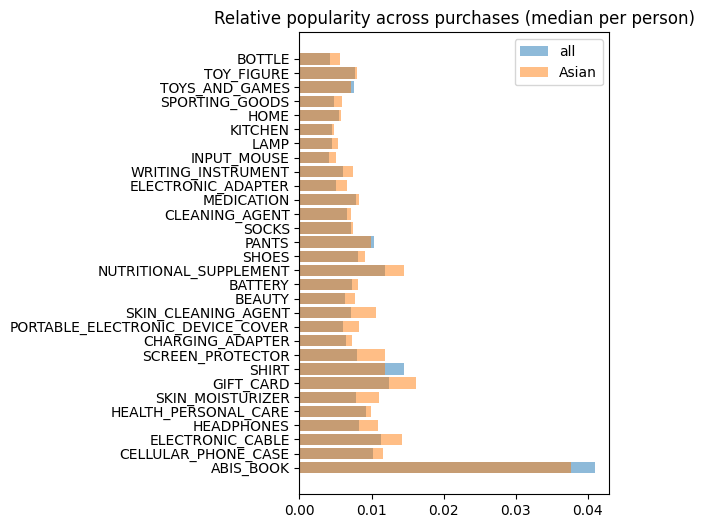

In [51]:
# take the top X categories that ppl in category have purchased from
tcats = asian_rel_purchasers.head(30)['Category'].to_list()
# and then plot their relative popularity
# tcats
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, asian_rel_popularity.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='Asian')
_ = ax.legend()

For demo d (e.g. race=black)

Restrict to categories where at least Y% made a purchase. 

Look at differences in relative popularity between demo d vs all, restricted to these categories

In [52]:
# Value counts for number of unique people who bought from the category
tcats_count = 20 # 30 performed worse than 20; i.e. 20 > 30
ppl_threshold_portion = 0.1 # performance: 0.1 > 0.15 > 0.2 > 0.3

In [53]:
print('For Black')
ppl_threshold = round(black_data_df[RESPONSE_ID].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

b_cats_ppl = black_data_df.groupby('Category')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('%s unique categories'% len(b_cats_ppl))
b_cats_ppl = b_cats_ppl[b_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(b_cats_ppl))
b_cats = b_cats_ppl.index
b_cats_ppl.head()

For Black
unique purchasers thershold: 45 (0.1)
1599 unique categories
333 categories above threshold


Category
ABIS_BOOK              350
ELECTRONIC_CABLE       293
CELLULAR_PHONE_CASE    289
HEADPHONES             288
SHIRT                  261
Name: Survey ResponseID, dtype: int64

In [54]:
b_diff = (
    (abs(black_rel_popularity.set_index('Category')['relative orders'].loc[b_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[b_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[b_cats])
    .rename('difference in rel popularity')
)
b_diff = b_diff.sort_values(ascending=False)
# b_diff.head(20)

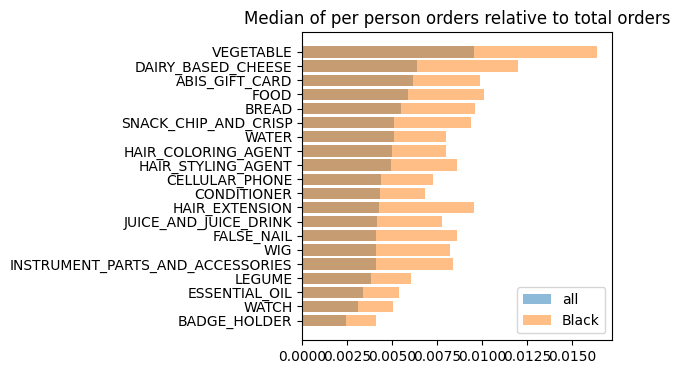

In [55]:
b_tcats = b_diff.head(tcats_count).index.to_list()
# sort by order frequency
b_tcats_sorted = (
    cat_rel_pop.set_index('Category').loc[b_tcats]['relative orders']
    .sort_values().index
)
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(b_tcats_sorted, cat_rel_pop.set_index('Category').loc[b_tcats_sorted]['relative orders'], alpha=0.5, label='all')
ax.barh(b_tcats_sorted, black_rel_popularity.set_index('Category').loc[b_tcats_sorted]['relative orders'], alpha=0.5, label='Black')
_ = ax.legend()

In [56]:
print('For Asian')
ppl_threshold = round(asian_data_df[RESPONSE_ID].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

a_cats_ppl = asian_data_df.groupby('Category')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('%s unique categories'% len(a_cats_ppl))
a_cats_ppl = a_cats_ppl[a_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(a_cats_ppl))
a_cats = a_cats_ppl.index
a_cats_ppl.head()

For Asian
unique purchasers thershold: 48 (0.1)
1624 unique categories
329 categories above threshold


Category
ABIS_BOOK               364
CELLULAR_PHONE_CASE     320
ELECTRONIC_CABLE        314
HEADPHONES              303
HEALTH_PERSONAL_CARE    267
Name: Survey ResponseID, dtype: int64

In [57]:
a_diff = (
    (abs(asian_rel_popularity.set_index('Category')['relative orders'].loc[a_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[a_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[a_cats])
    .rename('difference in rel popularity')
)
a_diff = a_diff.sort_values(ascending=False)
a_diff.head()

Category
MONITOR                             1.075533
ELECTRONIC_GIFT_CARD                0.831967
PROTEIN_SUPPLEMENT_POWDER           0.771985
SKIN_TREATMENT_MASK                 0.768325
PORTABLE_ELECTRONIC_DEVICE_STAND    0.714286
Name: difference in rel popularity, dtype: float64

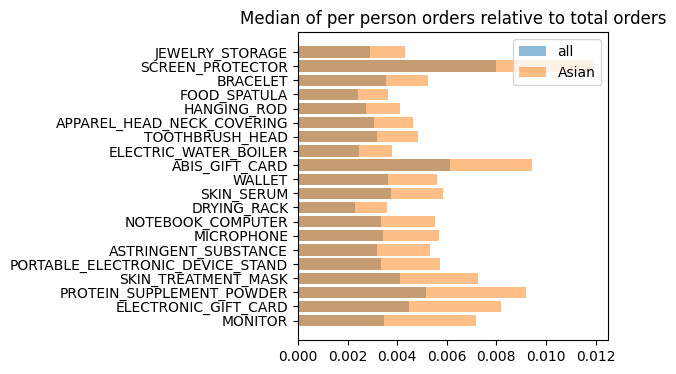

In [58]:
a_tcats = a_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(a_tcats, cat_rel_pop.set_index('Category').loc[a_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(a_tcats, asian_rel_popularity.set_index('Category').loc[a_tcats]['relative orders'], alpha=0.5, label='Asian')
_ = ax.legend()

Do the same for Hispanic

In [59]:
print('For Hispanic')
ppl_threshold = round(hisp_data_df[RESPONSE_ID].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

hisp_cats_ppl = hisp_data_df.groupby('Category')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('%s unique categories'% len(a_cats_ppl))
hisp_cats_ppl = hisp_cats_ppl[hisp_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(hisp_cats_ppl))
hisp_cats = hisp_cats_ppl.index
hisp_cats_ppl.head()

For Hispanic
unique purchasers thershold: 55 (0.1)
329 unique categories
358 categories above threshold


Category
ABIS_BOOK              438
ELECTRONIC_CABLE       380
CELLULAR_PHONE_CASE    378
HEADPHONES             366
SHIRT                  347
Name: Survey ResponseID, dtype: int64

In [60]:
hisp_diff = (
    (abs(hisp_rel_popularity.set_index('Category')['relative orders'].loc[hisp_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[hisp_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[hisp_cats])
    .rename('difference in rel popularity')
)
hisp_diff = hisp_diff.sort_values(ascending=False)
hisp_diff.head()

Category
WAIST_PACK                   0.569818
PROTEIN_SUPPLEMENT_POWDER    0.479470
SIGNAGE                      0.428798
JUICE_AND_JUICE_DRINK        0.423816
BODY_STRAP                   0.420942
Name: difference in rel popularity, dtype: float64

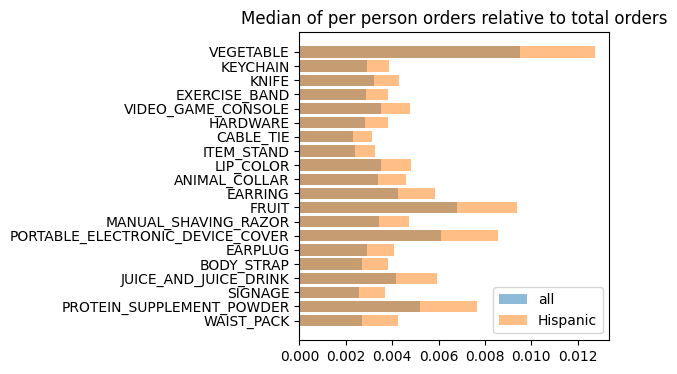

In [61]:
hisp_tcats = hisp_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(hisp_tcats, cat_rel_pop.set_index('Category').loc[hisp_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(hisp_tcats, hisp_rel_popularity.set_index('Category').loc[hisp_tcats]['relative orders'], alpha=0.5, label='Hispanic')
_ = ax.legend()

Do the same for diabetes

In [62]:
print('For diabetes')
ppl_threshold = round(diabetes_data_df[RESPONSE_ID].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

d_cats_ppl = diabetes_data_df.groupby('Category')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('%s unique categories'% len(d_cats_ppl))
d_cats_ppl = d_cats_ppl[d_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(d_cats_ppl))
d_cats = d_cats_ppl.index
d_cats_ppl.head()

For diabetes
unique purchasers thershold: 62 (0.1)
1685 unique categories
422 categories above threshold


Category
ABIS_BOOK               501
ELECTRONIC_CABLE        437
HEALTH_PERSONAL_CARE    413
HEADPHONES              407
CELLULAR_PHONE_CASE     405
Name: Survey ResponseID, dtype: int64

In [63]:
d_diff = (
    (abs(diabetes_cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats])
    .rename('difference in rel popularity')
)
d_diff = d_diff.sort_values(ascending=False)
d_diff.head()

Category
ELECTRONIC_GIFT_CARD         0.447213
WOUND_DRESSING               0.327648
PROTEIN_SUPPLEMENT_POWDER    0.326353
VIDEO_GAME_CONSOLE           0.308068
DESK                         0.295889
Name: difference in rel popularity, dtype: float64

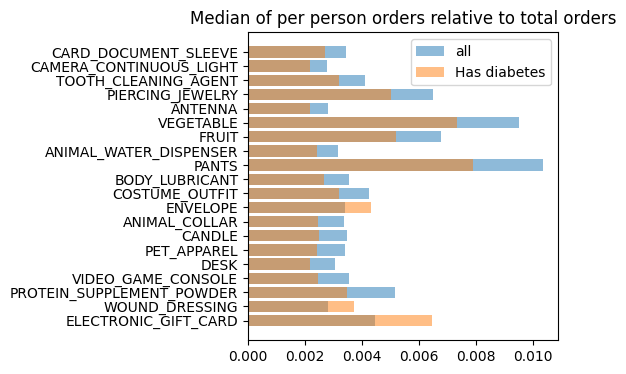

In [64]:
d_tcats = d_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(d_tcats, cat_rel_pop.set_index('Category').loc[d_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(d_tcats, diabetes_cat_rel_pop.set_index('Category').loc[d_tcats]['relative orders'], alpha=0.5, label='Has diabetes')
_ = ax.legend()

Are people with diabetes ordering fewer sex related items? 
And owning more pets?

What are these things?

In [65]:
data_df[data_df['Category'].isin([
    'BODY_LUBRICANT'
])].drop_duplicates('ASIN/ISBN (Product Code)')[data_df.columns[1:8]].head(3)

,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
15,14.72,1.0,NJ,"Slippery Stuff, 16 oz Gel, Clear, Pound , Unsc...",B00I7DT454,BODY_LUBRICANT,R_01vNIayewjIIKMF
46,3.75,1.0,NJ,Wet Naturals Beautifully Bare - 3.3 fl oz,B000QD9C8M,BODY_LUBRICANT,R_01vNIayewjIIKMF
49,10.49,1.0,NJ,"LubeLife Water-Based Personal Lubricant, Lube ...",B07DGQ4QR3,BODY_LUBRICANT,R_01vNIayewjIIKMF


## Models

In [66]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm

### Make the feature vectors

Assume n categories chosen for features

x_i = [x1, x2, ...,xn] for the n categories chosen

where each element is the relative orders of that item. i.e. number of unique purchases for that item relative to total purchases for person i.

In [67]:
def get_category_one_hot_encodings(df, cat):
    return ((df[df['Category']==cat]
        .groupby([RESPONSE_ID])['Order Date'].count() > 0)
        .reindex(df[RESPONSE_ID].unique())
        .fillna(0)
        .astype(int))

def get_relative_orders(df, cat):
    """Returns relative orders for category cat for each ResponseId in dataframe df."""
    return (df[df['Category']==cat].groupby([RESPONSE_ID])['Order Date'].nunique()\
        /df.groupby([RESPONSE_ID])['Order Date'].nunique()).fillna(0).to_list()

def get_data_one_hot_encording_for_categories(df, cats, Ycol):
    X_dict = {cat: get_category_one_hot_encodings(df, cat) for cat in cats}
    X_dict[RESPONSE_ID] = df[RESPONSE_ID].unique()
    data = pd.DataFrame(X_dict).set_index(RESPONSE_ID)
    Y = df.drop_duplicates(RESPONSE_ID).set_index(RESPONSE_ID)[Ycol].astype(int)
    data[Ycol] = Y
    return data

def get_data_rel_orders_for_categories(df, cats, Ycol):
    X_dict = {cat: get_relative_orders(df, cat) for cat in cats}
    X_dict[RESPONSE_ID] = df[RESPONSE_ID].unique()
    data = pd.DataFrame(X_dict).set_index(RESPONSE_ID)
    Y = df.drop_duplicates(RESPONSE_ID).set_index(RESPONSE_ID)[Ycol].astype(int)
    data[Ycol] = Y
    return data

In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_auc_plot_roc(clf, X_test, y_test, ylabel, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    probs = clf.predict_proba(X_test)
    # keep probabilities for positive outcomes only
    probs = probs[:, 1]
    # calculate auc
    auc = roc_auc_score(y_test, probs)
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    ax.plot(fpr, tpr, marker='.', label='%s; AUC=%.3f'%(ylabel, auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    print('ROC AUC=%.3f' % (auc))
    return auc

### Black

In [69]:
# define the dataset
data = get_data_rel_orders_for_categories(data_df, b_tcats, 'Black')
X, y = data.drop('Black',axis=1), data['Black']
print(X.shape, y.shape)
data.head()

(5015, 20) (5015,)


,HAIR_EXTENSION,FALSE_NAIL,INSTRUMENT_PARTS_AND_ACCESSORIES,WIG,DAIRY_BASED_CHEESE,JUICE_AND_JUICE_DRINK,SNACK_CHIP_AND_CRISP,BREAD,HAIR_STYLING_AGENT,VEGETABLE,...,BADGE_HOLDER,CELLULAR_PHONE,WATCH,ABIS_GIFT_CARD,HAIR_COLORING_AGENT,ESSENTIAL_OIL,CONDITIONER,LEGUME,WATER,Black
Survey ResponseID,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,0.0,0.0,0.000000,0.0,0.025000,0.012500,0.000000,0.000000,0.0,0.000000,...,0.0,0.025,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
R_037XK72IZBJyF69,0.0,0.0,0.003401,0.0,0.044218,0.010204,0.017007,0.034014,0.0,0.030612,...,0.0,0.000,0.0,0.000000,0.003401,0.000000,0.017007,0.010204,0.0,0
R_038ZU6kfQ5f89fH,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
R_03aEbghUILs9NxD,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000,0.0,0.010989,0.000000,0.010989,0.000000,0.000000,0.0,0
R_06RZP9pS7kONINr,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.007576,0.000000,0.0,0


In [70]:
# define the dataset
data_1hot = get_data_one_hot_encording_for_categories(data_df, b_tcats, 'Black')
X_1hot, y_1hot = data_1hot.drop('Black',axis=1), data_1hot['Black']
print(X_1hot.shape, y_1hot.shape)
display(data_1hot.head())
y_1hot.head()

(5015, 20) (5015,)


,HAIR_EXTENSION,FALSE_NAIL,INSTRUMENT_PARTS_AND_ACCESSORIES,WIG,DAIRY_BASED_CHEESE,JUICE_AND_JUICE_DRINK,SNACK_CHIP_AND_CRISP,BREAD,HAIR_STYLING_AGENT,VEGETABLE,...,BADGE_HOLDER,CELLULAR_PHONE,WATCH,ABIS_GIFT_CARD,HAIR_COLORING_AGENT,ESSENTIAL_OIL,CONDITIONER,LEGUME,WATER,Black
Survey ResponseID,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
R_037XK72IZBJyF69,0,0,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,1,1,0,0
R_038ZU6kfQ5f89fH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_03aEbghUILs9NxD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
R_06RZP9pS7kONINr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Survey ResponseID
R_01vNIayewjIIKMF    1
R_037XK72IZBJyF69    0
R_038ZU6kfQ5f89fH    0
R_03aEbghUILs9NxD    0
R_06RZP9pS7kONINr    0
Name: Black, dtype: int64

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))

print('%s/%s Black in train data\n%s/%s Black in test data' % (y_train.sum(),len(y_train),y_test.sum(),len(y_test)))

data partitioned into  80-20 train-test split
train size = 4012; test size = 1003
355/4012 Black in train data
91/1003 Black in test data


Logistic regression
Mean accuracy: 0.8245
ROC AUC=0.669


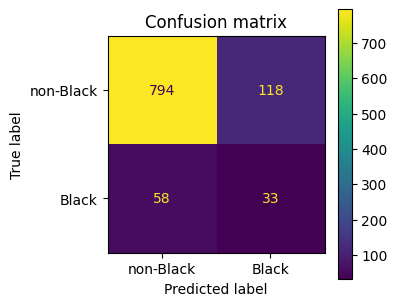

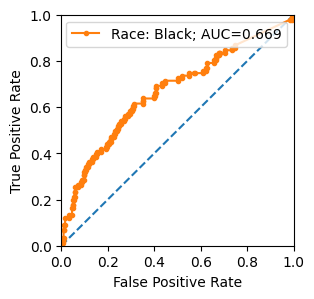

In [72]:
print('Logistic regression')
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-Black','Black'])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Black')

SVM
Mean accuracy: 0.8614
ROC AUC=0.683


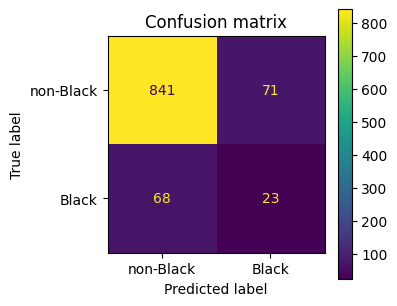

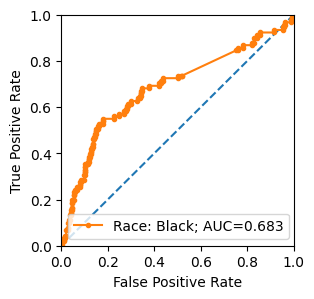

In [73]:
# Try SVM instead
print('SVM')
ycol = 'Black'
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Black')

### Asian

In [74]:
ycol = 'Asian'
cats = a_tcats
# define the dataset
data = get_data_rel_orders_for_categories(data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(5015, 20) (5015,)
data partitioned into  80-20 train-test split
train size = 4012; test size = 1003
387/4012 Asian in train data
95/1003 Asian in test data


Logistic regression
Mean accuracy: 0.7039
ROC AUC=0.612


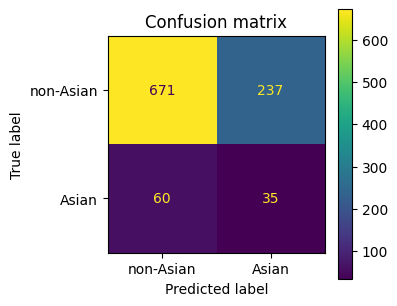

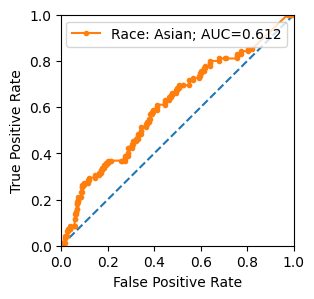

In [75]:
print('Logistic regression')
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Asian')

SVM
Mean accuracy: 0.7418
ROC AUC=0.648


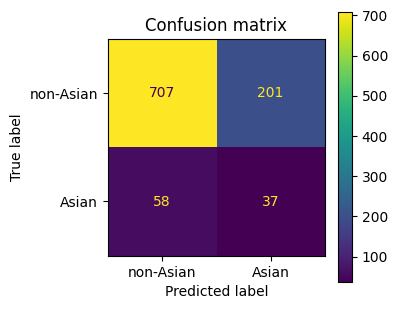

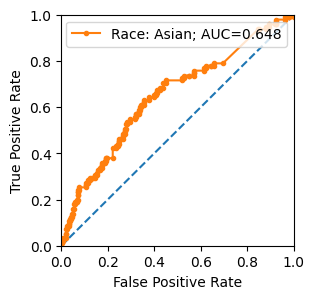

In [76]:
print('SVM')
# Try SVM instead
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Asian')

### Hispanic

In [77]:
# define the dataset
ycol = 'Hispanic'
data = get_data_rel_orders_for_categories(data_df, hisp_tcats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(5015, 20) (5015,)
(5015, 20) (5015,)
data partitioned into  80-20 train-test split
train size = 4012; test size = 1003
430/4012 Hispanic in train data
118/1003 Hispanic in test data


Logistic regression
Mean accuracy: 0.6929
ROC AUC=0.576


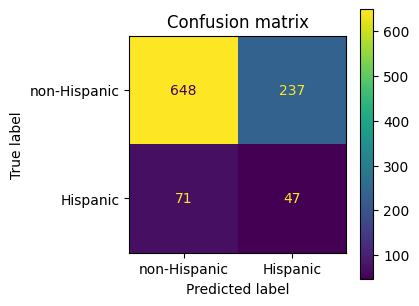

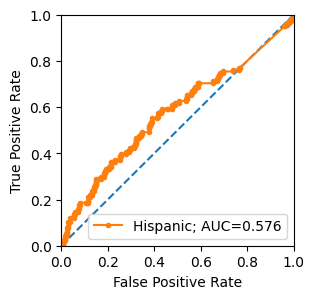

In [78]:
# train
print('Logistic regression')
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

SVM
Mean accuracy: 0.7109
ROC AUC=0.566


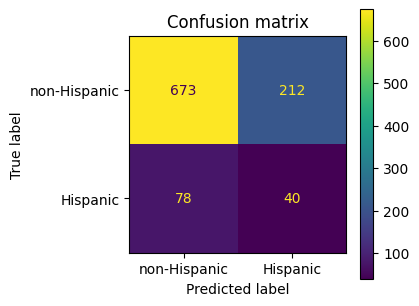

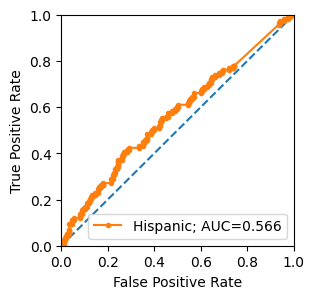

In [79]:
# Try SVM instead
print('SVM')
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### Diabetes

When asked if they have diabetes, some people answered 'Prefer not to say'.
Handle that by excluding their data.

In [80]:
# define the dataset
ycol = 'Diabetes'
data = get_data_rel_orders_for_categories(data_df, d_tcats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
data.head()

(5015, 20) (5015,)


,ELECTRONIC_GIFT_CARD,WOUND_DRESSING,PROTEIN_SUPPLEMENT_POWDER,VIDEO_GAME_CONSOLE,DESK,PET_APPAREL,CANDLE,ANIMAL_COLLAR,ENVELOPE,COSTUME_OUTFIT,...,PANTS,ANIMAL_WATER_DISPENSER,FRUIT,VEGETABLE,ANTENNA,PIERCING_JEWELRY,TOOTH_CLEANING_AGENT,CAMERA_CONTINUOUS_LIGHT,CARD_DOCUMENT_SLEEVE,Diabetes
Survey ResponseID,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,0.000000,0.000000,0.0,0.0125,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.012500,0.0,0.0,0
R_037XK72IZBJyF69,0.000000,0.003401,0.0,0.0000,0.003401,0.0,0.003401,0.006803,0.003401,0.0,...,0.040816,0.0,0.05102,0.030612,0.0,0.0,0.003401,0.0,0.0,0
R_038ZU6kfQ5f89fH,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0
R_03aEbghUILs9NxD,0.021978,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.021978,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0
R_06RZP9pS7kONINr,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.007576,0.007576,0.0,...,0.022727,0.0,0.00000,0.000000,0.0,0.0,0.007576,0.0,0.0,1


data partitioned into  80-20 train-test split
train size = 4012; test size = 1003
490/4012 Diabetes in train data
126/1003 Diabetes in test data
SVM
Mean accuracy: 0.4726
ROC AUC=0.569


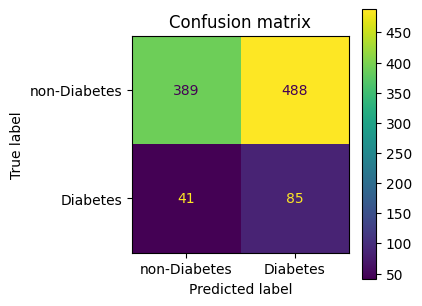

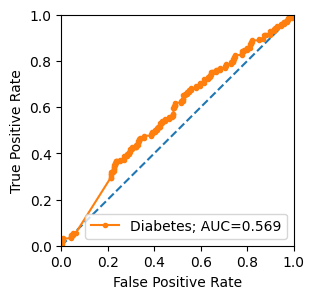

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))

print('%s/%s %s in train data\n%s/%s %s in test data' % (
    y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

print('SVM')
clf = svm.SVC(probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### How to encode feature vectors: Relative orders vs one-hot encoding

Which works better?

Above uses relative orders. Here try one-hot encoding.

Doesn't work nearly as well for Asian! Works about as well for diabetes.

In [84]:
ycol = 'Diabetes'
cats = d_tcats
# define the dataset
data = get_data_one_hot_encording_for_categories(data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(5015, 20) (5015,)


Mean accuracy: 0.5085
ROC AUC=0.538


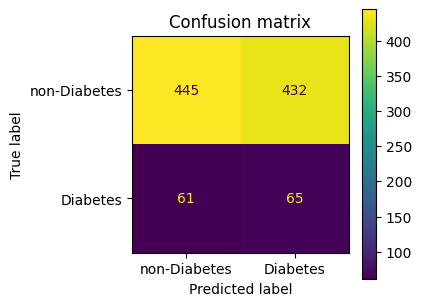

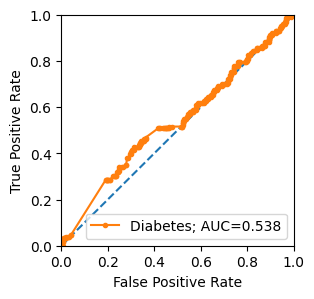

In [85]:
print('SVM')
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### Try another pipeline

- use larger set of categories to create feature vectors
- transform into n components with SVD

In [86]:
def get_lr_models(n_start, n_end, n_skip):
    models = dict()
    for n in range(n_start, n_end + n_skip, n_skip):
        models[str(n)] = Pipeline(steps=[
            ('svd', TruncatedSVD(n_components=n)), 
            ('m', LogisticRegression(class_weight='balanced'))
        ])
    return models

def get_svm_models(n_start, n_end, n_skip):
    models = dict()
    for n in range(n_start, n_end + n_skip, n_skip):
        models[str(n)] = Pipeline(steps=[
            ('svd', TruncatedSVD(n_components=n)), 
            ('m', svm.SVC(kernel='rbf', probability=True, class_weight='balanced'))
        ])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

def test_svd_ml_pipeline(X, y, ylabel, n_start=10, n_end=100, n_skip=5, svm=False, ax=None, verbose=False):
    """
    Tests a pipeline using SVD with n components then model (SVM or logistic regression)
    Uses k-fold cross validation and evaluates mean AUC
    Tests with component n ranging from n_start to n_end
    Plots AUC results
    Returns best n and corresponding AUC score
    """
    model_type = 'SVM' if svm else 'logistic regression'
    print('%s: %s' % (ylabel, model_type))
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
    # get the models to evaluate
    models = get_svm_models(n_start, n_end, n_skip) if svm else get_lr_models(n_start, n_end, n_skip)
    # track best n, best AUC
    best_n, best_AUC = 0, 0
    # evaluate the models and store results
    accuracy_scores_results, auc_scores_results, names = list(), list(), list()
    for name, model in models.items():
        accuracy_scores, auc_scores = evaluate_model(model, X, y)
        accuracy_scores_results.append(accuracy_scores)
        auc_scores_results.append(auc_scores)
        names.append(name)
        if mean(auc_scores) > best_AUC:
            if verbose:
                print('new best: n=%s' % name)
                print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
                print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
            best_n = name
            best_AUC = mean(auc_scores)
    # plot model performance for comparison
    ax.set_title('[%s] SVD --> %s' % (ylabel, model_type))
    _ = ax.boxplot(auc_scores_results, labels=names, showmeans=True)
    ax.set_ylabel('AUC')
    ax.set_xlabel('components')
    plt.show()
    return best_n, best_AUC

In [87]:
print('using %s categories' % len(categories))

using 1223 categories


In [88]:
ycol = 'Asian'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(5015, 1223) (5015,)
using k-fold instead of train-test split
482/5015 Asian in data


Asian: logistic regression
new best: n=10
>10 accuracy 0.573 (0.023)
>10 AUC 0.635 (0.040)
new best: n=15
>15 accuracy 0.619 (0.023)
>15 AUC 0.660 (0.039)
new best: n=20
>20 accuracy 0.628 (0.020)
>20 AUC 0.663 (0.039)
new best: n=25
>25 accuracy 0.631 (0.019)
>25 AUC 0.664 (0.039)
new best: n=30
>30 accuracy 0.632 (0.020)
>30 AUC 0.665 (0.039)
new best: n=35
>35 accuracy 0.638 (0.020)
>35 AUC 0.668 (0.037)
new best: n=40
>40 accuracy 0.642 (0.018)
>40 AUC 0.669 (0.036)
new best: n=45
>45 accuracy 0.647 (0.018)
>45 AUC 0.670 (0.036)
new best: n=50
>50 accuracy 0.649 (0.019)
>50 AUC 0.672 (0.037)
new best: n=55
>55 accuracy 0.653 (0.019)
>55 AUC 0.674 (0.037)
new best: n=60
>60 accuracy 0.658 (0.017)
>60 AUC 0.676 (0.037)
new best: n=65
>65 accuracy 0.661 (0.017)
>65 AUC 0.677 (0.037)
new best: n=70
>70 accuracy 0.664 (0.019)
>70 AUC 0.679 (0.037)
new best: n=75
>75 accuracy 0.668 (0.018)
>75 AUC 0.681 (0.036)
new best: n=80
>80 accuracy 0.670 (0.019)
>80 AUC 0.683 (0.036)
new best: n=8

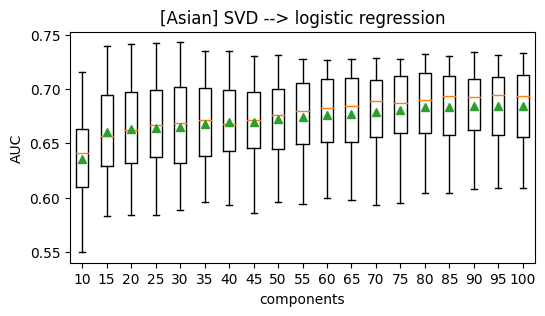

Asian
Logistic regression
Best: n=95; AUC=0.684


In [89]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Asian: SVM


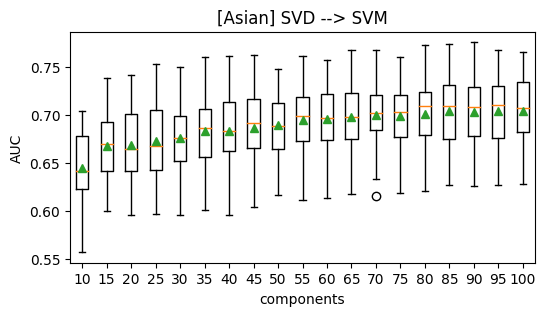

Asian
SVM regression
Best: n=100; AUC=0.704


In [90]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

### SVD pipeline for Black

In [91]:
ycol = 'Black'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(5015, 1223) (5015,)
using k-fold instead of train-test split
446/5015 Black in data


Black: logistic regression
new best: n=10
>10 accuracy 0.597 (0.024)
>10 AUC 0.650 (0.048)
new best: n=15
>15 accuracy 0.671 (0.018)
>15 AUC 0.680 (0.052)
new best: n=25
>25 accuracy 0.682 (0.017)
>25 AUC 0.685 (0.047)
new best: n=30
>30 accuracy 0.689 (0.018)
>30 AUC 0.690 (0.044)
new best: n=35
>35 accuracy 0.700 (0.017)
>35 AUC 0.703 (0.043)
new best: n=40
>40 accuracy 0.706 (0.018)
>40 AUC 0.708 (0.041)
new best: n=45
>45 accuracy 0.706 (0.015)
>45 AUC 0.711 (0.040)
new best: n=50
>50 accuracy 0.712 (0.016)
>50 AUC 0.719 (0.039)
new best: n=55
>55 accuracy 0.718 (0.015)
>55 AUC 0.724 (0.039)
new best: n=60
>60 accuracy 0.720 (0.017)
>60 AUC 0.726 (0.038)
new best: n=65
>65 accuracy 0.726 (0.016)
>65 AUC 0.728 (0.037)
new best: n=75
>75 accuracy 0.727 (0.017)
>75 AUC 0.729 (0.038)
new best: n=80
>80 accuracy 0.731 (0.016)
>80 AUC 0.730 (0.038)
new best: n=85
>85 accuracy 0.733 (0.016)
>85 AUC 0.732 (0.038)
new best: n=90
>90 accuracy 0.736 (0.017)
>90 AUC 0.735 (0.037)
new best: n=9

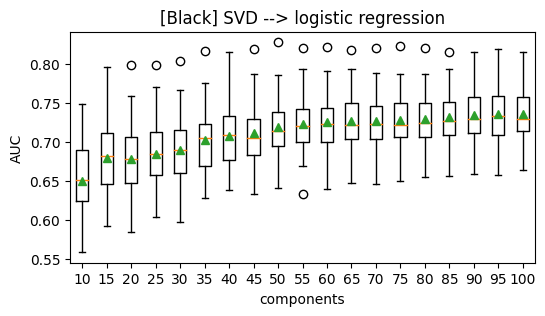

Black
Logistic regression
Best: n=100; AUC=0.736


In [92]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Black: SVM


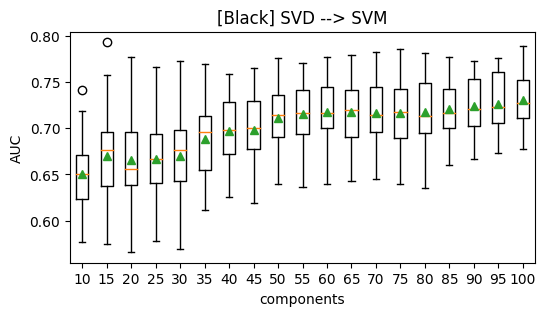

Black
SVM regression
Best: n=100; AUC=0.730


In [93]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

### For Hispanic

In [94]:
ycol = 'Hispanic'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(5015, 1223) (5015,)
using k-fold instead of train-test split
548/5015 Hispanic in data


Hispanic: logistic regression
new best: n=10
>10 accuracy 0.571 (0.025)
>10 AUC 0.572 (0.047)
new best: n=15
>15 accuracy 0.604 (0.025)
>15 AUC 0.592 (0.045)
new best: n=20
>20 accuracy 0.612 (0.023)
>20 AUC 0.600 (0.043)
new best: n=25
>25 accuracy 0.616 (0.023)
>25 AUC 0.605 (0.044)


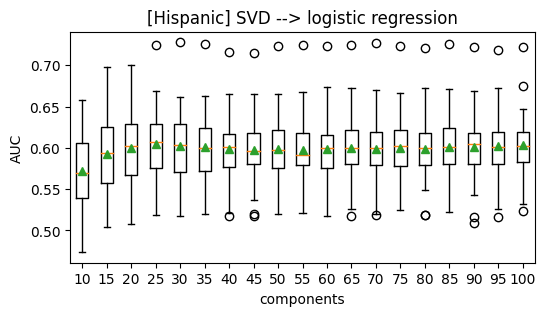

Hispanic
Logistic regression
Best: n=25; AUC=0.605


In [95]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Asian: SVM


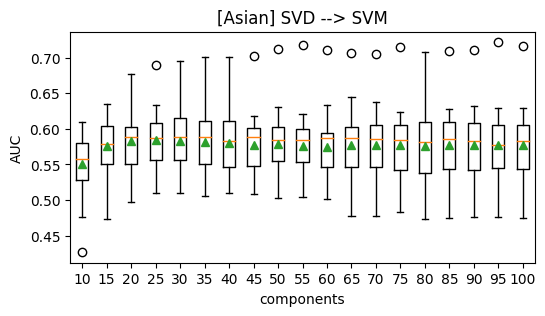

Hispanic
SVM regression
Best: n=25; AUC=0.584


In [96]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

## Another ML Pipeline: SVD over products purchased

one-hot encodings for product purchase. i.e. a product code is a feature, where 1=product was purchsed at any time; otherwise 0.

Limit to products that were purchased by X% of the ppl.

In [97]:
n_products = data_df['ASIN/ISBN (Product Code)'].nunique()
print('%s total product codes in dataset' % n_products)

888301 total product codes in dataset


In [133]:
# Limit to products that were purchased by X% of the ppl.
product_purchasers_threshold_pct = 0.01
print('limit to products purchased from %s of purchasers'%product_purchasers_threshold_pct)
products_purchasers_threshold = data_df[RESPONSE_ID].nunique() * product_purchasers_threshold_pct
print('%s total purchasers; %s purchasers = threshold'%(data_df[RESPONSE_ID].nunique(), products_purchasers_threshold))

limit to products purchased from 0.01 of purchasers
5015 total purchasers; 50.15 purchasers = threshold


In [99]:
# Get the number of purchasers per product code
product_purchasers_count = data_df.groupby('ASIN/ISBN (Product Code)')[RESPONSE_ID].nunique().sort_values(ascending=False)
product_purchasers_count.head()

ASIN/ISBN (Product Code)
B00IX1I3G6    1157
B086KKT3RX     769
B07PCMWTSG     519
B004LLIKVU     458
B07FZ8S74R     353
Name: Survey ResponseID, dtype: int64

Most products in our dataset were only purchased by one person

In [100]:
product_purchasers_count.describe()

count    888301.000000
mean          1.641583
std           3.406044
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1157.000000
Name: Survey ResponseID, dtype: float64

In [101]:
feature_products = product_purchasers_count[product_purchasers_count > products_purchasers_threshold]
print('using %s products for feature vectors' % len(feature_products))

using 456 products for feature vectors


Most of the top products are gift cards and batteries

In [102]:
print(feature_products.head())
feature_products = feature_products.index
(data_df[data_df['ASIN/ISBN (Product Code)'].isin(feature_products[:10])]
 .drop_duplicates('ASIN/ISBN (Product Code)')[data_df.columns[:8]].head(10))

ASIN/ISBN (Product Code)
B00IX1I3G6    1157
B086KKT3RX     769
B07PCMWTSG     519
B004LLIKVU     458
B07FZ8S74R     353
Name: Survey ResponseID, dtype: int64


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
81,2020-08-01,25.00,1.0,NaN,Amazon.com Gift Card Balance Reload,B00IX1I3G6,GIFT_CARD,R_01vNIayewjIIKMF
421,2020-04-30,25.00,2.0,NaN,Amazon.com eGift Card,B07PCMWTSG,GIFT_CARD,R_037XK72IZBJyF69
1039,2021-10-09,10.99,1.0,PA,Amazon Basics 36 Pack AAA High-Performance Alk...,B00LH3DMUO,BATTERY,R_037XK72IZBJyF69
1510,2021-08-11,6.78,1.0,NaN,Amazon Reload,B086KKT3RX,ABIS_GIFT_CARD,R_03aEbghUILs9NxD
1847,2021-11-27,19.99,1.0,NE,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3,R_06RZP9pS7kONINr
2610,2020-11-27,24.99,1.0,CA,"Amazon Smart Plug, works with Alexa – A Certif...",B01MZEEFNX,DIGITAL_DEVICE_3_ACCESSORY,R_0AjvU74YOfIrIpX
3119,2019-12-16,13.99,1.0,TX,Amazon Basics 48 Pack AA High-Performance Alka...,B00MNV8E0C,BATTERY,R_0BCm9hRP9iTI081
4297,2019-07-16,39.99,1.0,TN,Fire TV Stick streaming device with Alexa buil...,B0791TX5P5,DIGITAL_DEVICE_4,R_0D6GtQwa6VcnXpv
4353,2020-02-24,34.99,1.0,TN,Fire TV Stick 4K streaming device with Alexa V...,B079QHML21,DIGITAL_DEVICE_4,R_0D6GtQwa6VcnXpv
4661,2018-03-15,32.82,1.0,NaN,Amazon.com eGift Card,B004LLIKVU,GIFT_CARD,R_0DoXqOQl0hxEeFH


In [103]:
def get_one_hot_product_vectors(df, product_code):
    return ((df[df['ASIN/ISBN (Product Code)']==product_code]
            .groupby([RESPONSE_ID])['Order Date'].count() > 0)
            .reindex(df[RESPONSE_ID].unique())
            .fillna(0)
            .astype(int))

def get_one_hot_product_features_data(df, product_codes, Ycol):
    X_dict = {p: get_one_hot_product_vectors(df, p) for p in product_codes}
    X_dict[RESPONSE_ID] = df[RESPONSE_ID].unique()
    data = pd.DataFrame(X_dict).set_index(RESPONSE_ID)
    data[Ycol] = df.drop_duplicates(RESPONSE_ID).set_index(RESPONSE_ID)[Ycol].astype(int)
    return data

In [104]:
ycol = 'Black'
# define the dataset
data = get_one_hot_product_features_data(data_df, feature_products, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(5015, 456) (5015,)
using k-fold instead of train-test split
446/5015 Black in data


In [105]:
data.head(3)

,B00IX1I3G6,B086KKT3RX,B07PCMWTSG,B004LLIKVU,B07FZ8S74R,B079QHML21,B00LH3DMUO,B00MNV8E0C,B01MZEEFNX,B0791TX5P5,...,B00UASJM1K,B000P72UZG,B09B6V9Q8J,B01MSBQB1P,B07N316V8C,B01KBQ6I3A,B07GB3QXC6,B00BWF5U0M,1524763160,Black
Survey ResponseID,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
R_037XK72IZBJyF69,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_038ZU6kfQ5f89fH,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


>10 accuracy 0.483 (0.019)
>10 AUC 0.594 (0.040)
>14 accuracy 0.480 (0.023)
>14 AUC 0.588 (0.039)
>18 accuracy 0.479 (0.023)
>18 AUC 0.582 (0.038)
>22 accuracy 0.481 (0.026)
>22 AUC 0.582 (0.040)
>26 accuracy 0.488 (0.024)
>26 AUC 0.593 (0.034)
>30 accuracy 0.488 (0.024)
>30 AUC 0.594 (0.037)
>34 accuracy 0.498 (0.027)
>34 AUC 0.592 (0.040)
>38 accuracy 0.498 (0.026)
>38 AUC 0.595 (0.041)
>42 accuracy 0.503 (0.024)
>42 AUC 0.595 (0.037)
>46 accuracy 0.513 (0.025)
>46 AUC 0.591 (0.034)
>50 accuracy 0.521 (0.024)
>50 AUC 0.585 (0.036)
>54 accuracy 0.520 (0.026)
>54 AUC 0.587 (0.037)
>58 accuracy 0.524 (0.027)
>58 AUC 0.582 (0.033)
>62 accuracy 0.522 (0.023)
>62 AUC 0.588 (0.032)
>66 accuracy 0.524 (0.026)
>66 AUC 0.586 (0.037)
>70 accuracy 0.526 (0.024)
>70 AUC 0.587 (0.037)
>74 accuracy 0.526 (0.021)
>74 AUC 0.591 (0.035)
>78 accuracy 0.531 (0.022)
>78 AUC 0.587 (0.039)
>82 accuracy 0.537 (0.023)
>82 AUC 0.589 (0.034)
>86 accuracy 0.536 (0.018)
>86 AUC 0.588 (0.039)
>90 accuracy 0.534 (

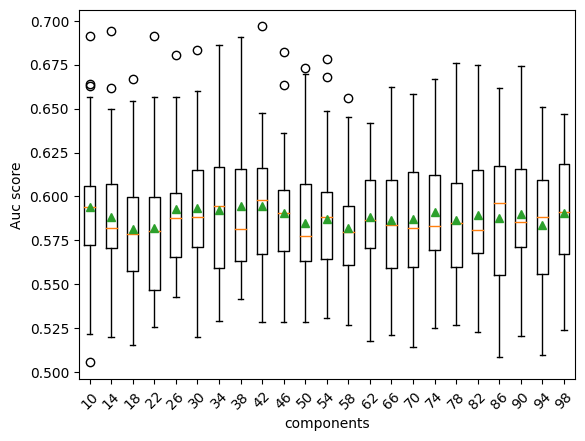

In [106]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 100,4):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(class_weight='balanced'))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
accuracy_scores_results, auc_scores_results, names = list(), list(), list()
for name, model in models.items():
    accuracy_scores, auc_scores = evaluate_model(model, X, y)
    accuracy_scores_results.append(accuracy_scores)
    auc_scores_results.append(auc_scores)
    names.append(name)
    print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
    print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
# plot model performance for comparison
plt.boxplot(auc_scores_results, labels=names, showmeans=True)
plt.xlabel('components')
plt.ylabel('Auc score')
plt.xticks(rotation=45)
plt.show()

## Inferring gender

Assumptions:

Gender differences will present themselves more in specific products vs categories.
- Results show this not so much the case?

Should be careful about:
- people sharing accounts or having larger households
- male/female binary vs others

So for this we initially limit data to:
- single_p_data_df: single person in household and using account
- people conforming to a male/female gender binary in response

In [107]:
data_df['Female'] = data_df['Q-demos-gender'].apply(lambda g: 1 if g=='Female' else 0)
data_df['Male'] = data_df['Q-demos-gender'].apply(lambda g: 1 if g=='Male' else 0)

Make data df for ppl who use their Amazon accounts for them alone
- Q-amazon-use-howmany = 1
- Q-amazon-use-hh-size = 1

How many people share the amazon account?
Q-amazon-use-howmany
1 (just me!)    3537
2               1093
3                245
4+               140
Name: count, dtype: int64
Household size
Q-amazon-use-hh-size
1 (just me!)    1197
2               1583
3                982
4+              1253
Name: count, dtype: int64


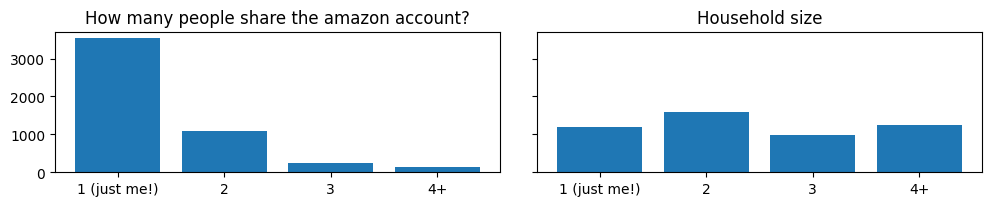

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10,2), sharey=True)
plt.tight_layout()
print('How many people share the amazon account?')
print(data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-howmany'].value_counts().sort_index())
ax = axes[0]
ax.set_title('How many people share the amazon account?')
ax.bar(
    data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-howmany'].value_counts().sort_index().index,
    data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-howmany'].value_counts().sort_index()
)
print('Household size')
print(data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-hh-size'].value_counts().sort_index())
ax = axes[1]
ax.set_title('Household size')
_ = ax.bar(
    data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-hh-size'].value_counts().sort_index().index,
    data_df.drop_duplicates(RESPONSE_ID)['Q-amazon-use-hh-size'].value_counts().sort_index()
)

Quick question:
Do Amazon accounts shared across more people end up making more purchases?

Answer: Yes

In [109]:
print('Median number of orders per account, by number of people sharing account')
orders_by_amazon_acct_size = (data_df.groupby(['Q-amazon-use-howmany', RESPONSE_ID])['Order Date']
 .nunique().rename('order counts').reset_index()
 .groupby('Q-amazon-use-howmany')['order counts'].median())
orders_by_amazon_acct_size

Median number of orders per account, by number of people sharing account


Q-amazon-use-howmany
1 (just me!)     79.0
2               180.0
3               226.0
4+              251.0
Name: order counts, dtype: float64

Quick question:
Do Amazon accounts for larger households make more purchases?

In [110]:
print('Median number of orders per account, by household size')
orders_by_hh_size = (data_df.groupby(['Q-amazon-use-hh-size', RESPONSE_ID])['Order Date']
 .nunique().rename('order counts').reset_index()
 .groupby('Q-amazon-use-hh-size')['order counts'].median())
orders_by_hh_size

Median number of orders per account, by household size


Q-amazon-use-hh-size
1 (just me!)     87.0
2               121.0
3                98.0
4+              121.0
Name: order counts, dtype: float64

Make dataframe restricted to purchases from people who do not share account and have household size of 1.

In [111]:
single_p_data_df = data_df[(
    (data_df['Q-amazon-use-hh-size']=='1 (just me!)') \
    & (data_df['Q-amazon-use-howmany']=='1 (just me!)'))]
print('limiting to data from single purchasers:')
print('%0.2f = %s/%s purchasers; %0.2f = %s/%s total purchases' % (
    single_p_data_df[RESPONSE_ID].nunique()/data_df[RESPONSE_ID].nunique(),
    single_p_data_df[RESPONSE_ID].nunique(), data_df[RESPONSE_ID].nunique(),
    len(single_p_data_df)/len(data_df), len(single_p_data_df), len(data_df)
))
single_p_data_df.head(3)

limiting to data from single purchasers:
0.22 = 1084/5015 purchasers; 0.16 = 275187/1737058 total purchases


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,yyyy-mm,...,income-collapsed,Hispanic,White,Black,Asian,LGBTQ+,Diabetes,Wheelchair,Female,Male
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,2018-12,...,"Less than $50,000",True,False,True,False,False,False,False,0,1
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,2018-12,...,"Less than $50,000",True,False,True,False,False,False,False,0,1
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF,2018,2018-12,...,"Less than $50,000",True,False,True,False,False,False,False,0,1


### Inspect gender

In [112]:
print('%s total respondents in all data' % data_df[RESPONSE_ID].nunique())
(
    data_df.drop_duplicates(RESPONSE_ID)['Q-demos-gender'].value_counts().sort_index() \
    /data_df.drop_duplicates(RESPONSE_ID)['Q-demos-gender'].value_counts().sum()
).round(3)

5015 total respondents in all data


Q-demos-gender
Female               0.516
Male                 0.459
Other                0.023
Prefer not to say    0.002
Name: count, dtype: float64

In [113]:
print('%s total respondents in single purchasers data' % single_p_data_df[RESPONSE_ID].nunique())
(
    single_p_data_df.drop_duplicates(RESPONSE_ID)['Q-demos-gender'].value_counts().sort_index() \
    /single_p_data_df.drop_duplicates(RESPONSE_ID)['Q-demos-gender'].value_counts().sum()
).round(3)

1084 total respondents in single purchasers data


Q-demos-gender
Female               0.496
Male                 0.470
Other                0.030
Prefer not to say    0.004
Name: count, dtype: float64

Make gender dataframe where
- restricted to respondents who answered with male/female binary
- restricted to respondents who do not share their amazon account and have household size of 1
- Male=0/1
- Female=0/1

In [114]:
gender_data_df = single_p_data_df[(single_p_data_df['Female'] + single_p_data_df['Male']) > 0]
female_data_df = single_p_data_df[single_p_data_df['Female']==1]
male_data_df = single_p_data_df[single_p_data_df['Male']==1]

How do top categories differ by Male/Female?

In [115]:
female_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': [get_relative_spend(female_data_df, c) for c in categories]
}).sort_values('relative spend', ascending=False)
female_rel_spend.head(15)

,Category,relative spend
424,GPS_OR_NAVIGATION_SYSTEM,0.078551
67,NOTEBOOK_COMPUTER,0.067034
593,IGNITION_COIL,0.064727
1114,COMPUTER_PROCESSOR,0.051514
254,SOFA,0.050506
770,MOTHERBOARD,0.047591
135,ELECTRICITY_GENERATOR,0.044576
408,TABLET_COMPUTER,0.041624
61,CAMERA_DIGITAL,0.038641
143,VIDEO_CARD,0.038465


In [116]:
female_rel_pop = pd.DataFrame({
    'Category': categories,
    'relative orders': [get_relative_popularity(female_data_df, c) for c in categories]
}).sort_values('relative orders', ascending=False)
female_rel_pop.head(15)

/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Category,relative orders
593,IGNITION_COIL,0.046172
342,ABIS_BOOK,0.042774
588,PET_FOOD,0.021930
75,WEATHER_STATION,0.016266
508,VEGETABLE,0.015564
62,SHIRT,0.014925
181,NUTRITIONAL_SUPPLEMENT,0.013514
835,GIFT_CARD,0.010811
376,ANIMAL_LITTER,0.010391
335,PANTS,0.010264


Look at differences in relative spend and orders for female vs everyone else

In [117]:
print('For Female')
ppl_threshold = round(female_data_df[RESPONSE_ID].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

female_cats_ppl = female_data_df.groupby('Category')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('%s unique categories'% len(female_cats_ppl))
female_cats_ppl = female_cats_ppl[female_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(female_cats_ppl))
female_cats = female_cats_ppl.index
female_cats_ppl.head()

For Female
unique purchasers thershold: 54 (0.1)
1613 unique categories
368 categories above threshold


Category
ABIS_BOOK               482
SHIRT                   357
HEALTH_PERSONAL_CARE    349
CELLULAR_PHONE_CASE     349
ELECTRONIC_CABLE        346
Name: Survey ResponseID, dtype: int64

In [118]:
female_pop_diff = (
    (abs(female_rel_pop.set_index('Category')['relative orders'].loc[female_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[female_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[female_cats])
    .rename('difference in rel popularity')
)
female_pop_diff = female_pop_diff.sort_values(ascending=False)
female_spend_diff = (
    (abs(female_rel_spend.set_index('Category')['relative spend'].loc[female_cats] \
      - cat_rel_spend.set_index('Category')['relative spend'].loc[female_cats]) \
     /cat_rel_spend.set_index('Category')['relative spend'].loc[female_cats])
    .rename('difference in rel spend')
)
female_spend_diff = female_spend_diff.sort_values(ascending=False)
female_spend_diff.head(10)
# female_pop_diff.head(20)

Category
FERTILIZER                       0.894844
HANGING_ROD                      0.795033
CULINARY_SALT                    0.780676
DRYING_RACK                      0.773390
INKJET_PRINTER_INK               0.762698
ANIMAL_NUTRITIONAL_SUPPLEMENT    0.742655
ANIMAL_LITTER                    0.721114
FLATWARE                         0.715681
CLOTHES_HANGER                   0.708468
TUNIC                            0.677243
Name: difference in rel spend, dtype: float64

In [119]:
female_pop_diff.head(10)

Category
TUNIC                      0.736559
ANIMAL_LITTER              0.681422
CULINARY_SALT              0.634483
VEGETABLE                  0.634241
MICROPHONE                 0.590702
EDIBLE_OIL_VEGETABLE       0.574572
FOOD_SLICER                0.574468
DECORATIVE_PILLOW_COVER    0.571795
ESSENTIAL_OIL              0.550877
FERTILIZER                 0.539743
Name: difference in rel popularity, dtype: float64

In [120]:
# defining top categories by spend
female_tcats = female_pop_diff.head(tcats_count).index.to_list()

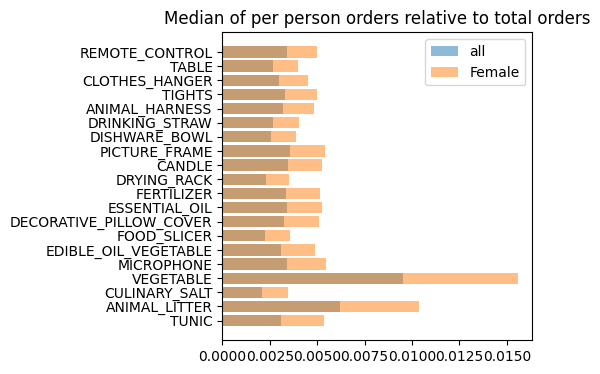

In [121]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(female_tcats, cat_rel_pop.set_index('Category').loc[female_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(female_tcats, female_rel_pop.set_index('Category').loc[female_tcats]['relative orders'], alpha=0.5, label='Female')
_ = ax.legend()

### Gender models

By category

In [122]:
ycol = 'Female'
cats = female_tcats
# define the dataset
data = get_data_rel_orders_for_categories(gender_data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(1048, 20) (1048,)
data partitioned into  80-20 train-test split
train size = 838; test size = 210
430/838 Female in train data
108/210 Female in test data


Mean accuracy: 0.6476
ROC AUC=0.727


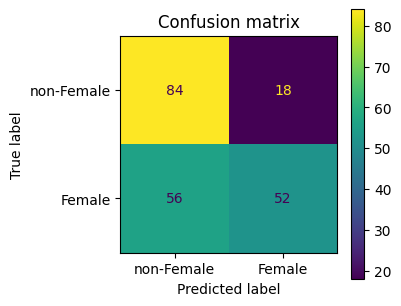

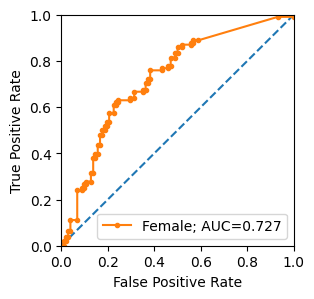

In [123]:
# Simple logistic regression
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

Mean accuracy: 0.6619
ROC AUC=0.756


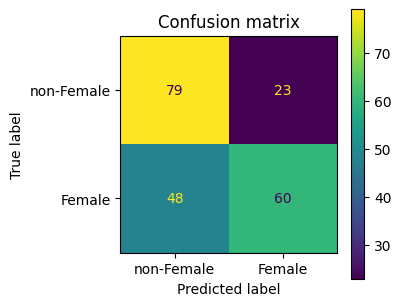

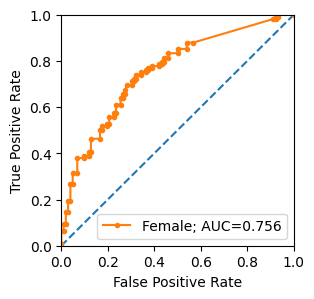

In [124]:
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

Use pipeline with SVD:
- use larger set of categories to create feature vectors
- transform into n components with SVD
- apply model

In [125]:
print('using %s categories' % len(categories))

using 1223 categories


In [126]:
# define the dataset
print(ycol)
data = get_data_rel_orders_for_categories(gender_data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

Female
(1048, 1223) (1048,)
using k-fold instead of train-test split
538/1048 Female in data


Female: logistic regression


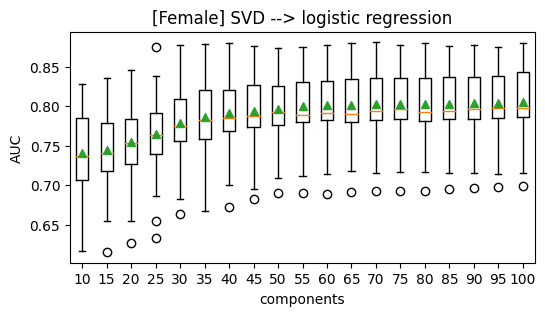

Female
Logistic regression
Best: n=100; AUC=0.805


In [127]:
lr_best_n, lr_best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=False)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Female: SVM


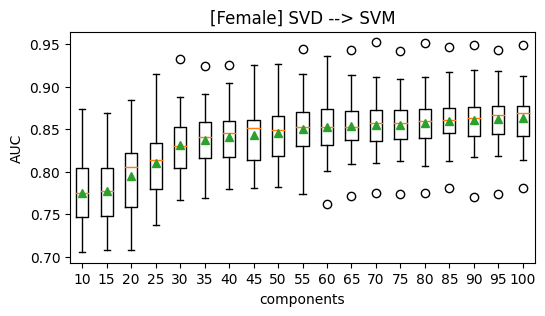

Female
SVM regression
Best: n=100; AUC=0.863


In [128]:
svm_best_n, svm_best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

#### Modeling for product vectors

one-hot encodings for product purchase. i.e. a product code is a feature, where 1=product was purchsed at any time; otherwise 0.

Limit to products that were purchased by X% of the ppl.

In [129]:
n_products_g = gender_data_df['ASIN/ISBN (Product Code)'].nunique()
print('%s total product codes in gender dataset' % n_products_g)

# Limit to products that were purchased by X% of the ppl.
product_purchasers_threshold_pct = 0.01
print('limit to products purchased from %s of purchasers'%product_purchasers_threshold_pct)
products_purchasers_threshold_g = round(gender_data_df[RESPONSE_ID].nunique() * product_purchasers_threshold_pct)
print('%s total purchasers; %s purchasers = threshold'%(gender_data_df[RESPONSE_ID].nunique(), products_purchasers_threshold_g))

177228 total product codes in gender dataset
limit to products purchased from 0.01 of purchasers
1048 total purchasers; 10 purchasers = threshold


In [130]:
# Get the number of purchasers per product code
product_purchasers_count_g = gender_data_df.groupby('ASIN/ISBN (Product Code)')[RESPONSE_ID].nunique().sort_values(ascending=False)
print('purchasers by product: distribution')
print(product_purchasers_count_g.describe())
gender_feature_products = product_purchasers_count_g[product_purchasers_count_g > products_purchasers_threshold_g]
print('\nusing %s products for gender feature vectors' % len(gender_feature_products))
gender_feature_products = gender_feature_products.index
(gender_data_df[gender_data_df['ASIN/ISBN (Product Code)'].isin(gender_feature_products[:8])]
 .drop_duplicates('ASIN/ISBN (Product Code)')[gender_data_df.columns[:8]].head(10))

purchasers by product: distribution
count    177228.000000
mean          1.250508
std           1.264545
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         222.000000
Name: Survey ResponseID, dtype: float64

using 370 products for gender feature vectors


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
81,2020-08-01,25.00,1.0,NaN,Amazon.com Gift Card Balance Reload,B00IX1I3G6,GIFT_CARD,R_01vNIayewjIIKMF
2508,2022-08-24,7.00,1.0,NaN,Amazon Reload,B086KKT3RX,ABIS_GIFT_CARD,R_08uYA7fb4unHGkF
2610,2020-11-27,24.99,1.0,CA,"Amazon Smart Plug, works with Alexa – A Certif...",B01MZEEFNX,DIGITAL_DEVICE_3_ACCESSORY,R_0AjvU74YOfIrIpX
13867,2021-11-05,100.00,1.0,NaN,Amazon eGift Card - Birthday Cupcakes,B07TMNGSN4,GIFT_CARD,R_0jFt3K3i4558lbj
31626,2019-07-16,24.99,1.0,AL,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3,R_11cJ3be1pQV32hb
40523,2020-09-26,125.00,1.0,NaN,Amazon.com eGift Card,B004LLIKVU,GIFT_CARD,R_12bxXZmV1h6iVAL
45876,2019-02-01,39.99,1.0,IN,Fire TV Stick 4K streaming device with Alexa V...,B079QHML21,DIGITAL_DEVICE_4,R_1BPepcPkpmd3HIv
55329,2021-04-26,10.00,1.0,NaN,Amazon.com eGift Card,B07PCMWTSG,GIFT_CARD,R_1C9JNFshblsSjyF


In [131]:
# define the dataset
print(ycol)
data = get_one_hot_product_features_data(gender_data_df, gender_feature_products, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

Female
(1048, 370) (1048,)
using k-fold instead of train-test split
538/1048 Female in data


>10 accuracy 0.619 (0.045)
>10 AUC 0.665 (0.042)
>14 accuracy 0.614 (0.040)
>14 AUC 0.659 (0.038)
>18 accuracy 0.603 (0.043)
>18 AUC 0.661 (0.043)
>22 accuracy 0.606 (0.045)
>22 AUC 0.662 (0.043)
>26 accuracy 0.610 (0.038)
>26 AUC 0.674 (0.042)
>30 accuracy 0.617 (0.045)
>30 AUC 0.674 (0.042)
>34 accuracy 0.608 (0.044)
>34 AUC 0.676 (0.040)
>38 accuracy 0.615 (0.047)
>38 AUC 0.680 (0.046)
>42 accuracy 0.621 (0.044)
>42 AUC 0.681 (0.044)
>46 accuracy 0.618 (0.050)
>46 AUC 0.688 (0.042)
>50 accuracy 0.624 (0.051)
>50 AUC 0.689 (0.042)
>54 accuracy 0.627 (0.047)
>54 AUC 0.692 (0.048)
>58 accuracy 0.621 (0.053)
>58 AUC 0.697 (0.040)
>62 accuracy 0.622 (0.054)
>62 AUC 0.693 (0.040)
>66 accuracy 0.623 (0.054)
>66 AUC 0.692 (0.043)
>70 accuracy 0.622 (0.051)
>70 AUC 0.702 (0.042)
>74 accuracy 0.625 (0.049)
>74 AUC 0.696 (0.045)
>78 accuracy 0.626 (0.060)
>78 AUC 0.698 (0.041)
>82 accuracy 0.625 (0.052)
>82 AUC 0.700 (0.040)
>86 accuracy 0.625 (0.047)
>86 AUC 0.700 (0.044)
>90 accuracy 0.628 (

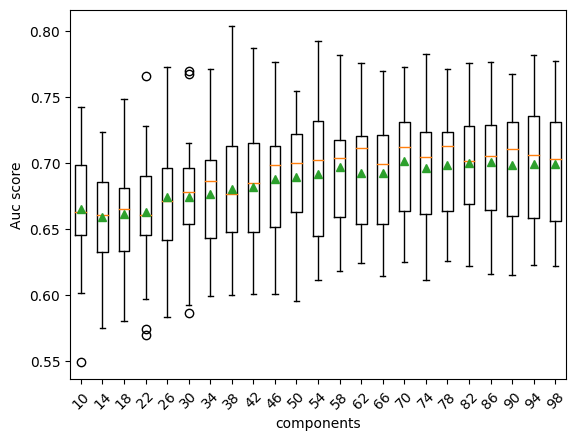

In [132]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 100,4):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(class_weight='balanced'))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
accuracy_scores_results, auc_scores_results, names = list(), list(), list()
for name, model in models.items():
    accuracy_scores, auc_scores = evaluate_model(model, X, y)
    accuracy_scores_results.append(accuracy_scores)
    auc_scores_results.append(auc_scores)
    names.append(name)
    print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
    print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
# plot model performance for comparison
plt.boxplot(auc_scores_results, labels=names, showmeans=True)
plt.xlabel('components')
plt.ylabel('Auc score')
plt.xticks(rotation=45)
plt.show()

### Outcomes

Modeling with category codes works better than product codes (with current dataset size)

### TODO

- see difference when testing gender without single purchaser restrictions